- TAD length -> kb
- TAD density -> n_promoters per kb

In [ ]:
!jupyter --version
!python3 --version


Selected Jupyter core packages...
IPython          : 7.34.0
ipykernel        : 5.5.6
ipywidgets       : 7.7.1
jupyter_client   : 6.1.12
jupyter_core     : 5.7.2
jupyter_server   : 1.24.0
jupyterlab       : not installed
nbclient         : 0.10.0
nbconvert        : 6.5.4
nbformat         : 5.10.4
notebook         : 6.5.5
qtconsole        : not installed
traitlets        : 5.7.1
Python 3.10.12


In [ ]:
# Import packages and Drive

#!pip install hic-straw
# import hicstraw

from google.colab import drive
drive.mount('/content/drive')

!pip install pybedtools
!apt-get install bedtools
import pybedtools

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec

import itertools
import random
import time
import re

from types import MappingProxyType
from collections import Counter
import statistics
from scipy.stats import norm
from scipy.stats import kstest

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 17.1 MB/s eta 0:00:00
  Created wheel for pybedtools: filename=pybedtools-0.10.0-cp310-cp310-linux_x86_64.whl size=14164840 sha256=b3991d28feb2ea6785b1eeaac421f5337ef51d2d1069e21246c38a4fadf34f6c
  Stored in directory: /root/.cache/pip/wheels/e5/26/a4/6913af11fdcfbc926c98fee0768b4fe955f6e3cc7ebe2c9d9e
Successfully built pybedtools
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 563 kB of archives.
After this operation, 1,548 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 bedtools amd64 2.30.0+dfsg-2ubuntu0.1 [563 kB]
Fetched 563 kB in 1s (563

In [ ]:
# Promoter.py
class Promoter():

    all_promoters = {}  # idenitfier : instance
    chromosomes = []
    cluster_members = {}
    matrix_indexes = ''
    promoter_contacts = {}
    cluster_segments = {}

    def __init__(self, chromosome, start, end, identifier, strand, cluster):
        # Define the attributes of the instances and their values
        self.chromosome = chromosome
        self.start = int(start)
        self.end = int(end)
        self.identifier = identifier
        self.strand = strand
        self.cluster = cluster
        self.tads = {} # { TAD_instance : [Bin3, Bin4] }

        self.index = ''
        self.n_interactions = 0

        # Record promoter in all_promoters
        if self.identifier not in self.__class__.all_promoters:
          self.__class__.all_promoters[self.identifier] = self
        else:
          print(f'WARNING: there are two elements with the same ID {identifier}')

    @classmethod
    def LoadFromBedfile(cls, bedfile, cluster):
        with open(bedfile, 'r') as file:
            for line in file:
                # Split the line into columns
                columns = line.strip().split('\t')
                feature = cls(
                    chromosome=columns[0],
                    start=columns[1],
                    end=columns[2],
                    identifier=columns[3],
                    strand=columns[5],
                    cluster=cluster
                    )
                cls.cluster_members[cluster].append(feature)
                if cluster == 'cluster1A' or cluster == 'cluster1B':
                  cls.cluster_members['cluster1'].append(feature)

    @classmethod
    def RetrieveClusterMembers(cls, cluster_name, rest='Not'):
        promoters = cls.all_promoters.values()
        if cluster_name == 'all':
            return promoters
        else:
            if rest == 'Yes':
                cluster_instances = [promoter for promoter in promoters if promoter.cluster != cluster_name]
            else:
                cluster_instances = [promoter for promoter in promoters if promoter.cluster == cluster_name]
            return cluster_instances
    @classmethod
    def RetrieveChrMembers(cls, chr):
        promoters = cls.all_promoters.values()
        chr_instances = [promoter for promoter in promoters if promoter.chromosome == chr]
        return chr_instances

    @classmethod
    def CreateMatrixIndexes(cls, clusters):
        i = 0
        for cluster in clusters:
            promoter_members = cls.RetrieveClusterMembers(cluster)
            for promoter in promoter_members:
                promoter.index = i
                i += 1

    @classmethod
    def RestartNInteractions(cls):
        for promoter in cls.all_promoters.values():
            promoter.n_interactions = 0
    @classmethod
    def CreateRandomClusters(cls, cluster_sizes):
        promoters_list = [promoter for promoter in Promoter.all_promoters.values()]
        # Suffle the order of promoters
        random.shuffle(promoters_list)
        i, j= 0, 0
        flag = True
        for cluster, size in cluster_sizes.items():
            if flag:
                i = 0
                j = i + size - 1
                flag = False
            else:
                i = j + 1
                j = i + size - 1
            for promoter in promoters_list[i:j]:
                promoter.cluster = cluster

    @classmethod
    def SetOriginalClusters(cls, option):
      cluster_members = cls.cluster_members.copy()
      if option == 'cluster1AB':
        cluster_members.pop('cluster1')
      else:
        cluster_members.pop('cluster1A')
        cluster_members.pop('cluster1B')

      for cluster, members in cluster_members.items():
        for member in members:
          member.cluster = cluster

    def LoadTad(self, tad_instance, bin):
        if tad_instance == 'Bin0' and bin == 'Bin0':
            self.tads['Bin0'] = ['Bin0']
        else:
            if tad_instance in self.tads:
                self.tads[tad_instance].append(bin)
            else:
                self.tads[tad_instance] = [bin]
    def DeleteInstance(self):
        del Promoter.all_promoters[self.identifier]
        del self

In [ ]:
# Tad.py

class Tad():
    chromosomes = []
    bins = []
    all_tads = {} # { chr : { tad_ID : tad_instance } }

    def __init__(self, chromosome, start, end, compartment):
        # Define the attributes of the instances and their values
        self.chromosome = chromosome
        self.start = int(start)
        self.end = int(end)
        self.compartment = compartment
        self.identifier = f'TAD{start}-{end}'

        self.length = (self.end - self.start)/1000000 # mb
        self.promoters_in_tads = {bin: [] for bin in self.bins} # {'Bin0' : [promoter_instances], 'Bin1' : [promoter_instances]...}
        self.promoters_density = [0, ''] # density number, category (HD, MD or LD)
        self.specificity = {}

        self.all_tads[self.chromosome][self.identifier] = self

    @classmethod
    def LoadFromBedfile(cls, bedfile):
        with open(bedfile, 'r') as file:
            for line in file:
                # Split the line into columns
                columns = line.strip().split('\t')
                tad = cls(
                    chromosome=columns[0],
                    start=columns[1],
                    end=columns[2],
                    compartment=columns[3]
                    )
    @classmethod
    def RetrieveAllTads(cls):
        all_tads = [value for inner_dict in cls.all_tads.values() for value in inner_dict.values()]
        return all_tads

    @classmethod
    def CategorizeInDensities(cls):
      densities = {}
      all_tads = cls.RetrieveAllTads()
      for instance in all_tads:
        instance.CalculateDensity()
        densities[instance] = instance.promoters_density

      sorted_densities = dict(sorted(densities.items(), key=lambda item: item[1]))
      items = list(sorted_densities.items())
      chunk_size = (len(items) + 2) // 3  # Calculate chunk size rounding up. +2 pq es num_partes - 1 para segurar q coges todos
      densities = ['LD', 'MD', 'HD']
      for i in range(3):
          for tad, density_value in items[i * chunk_size:(i + 1) * chunk_size]:
              tad.promoters_density = [density_value[0], densities[i]]

    # reejecutar cambiando promoter.cluster a 1 y clusters a 1
    @classmethod
    def CalculateSpecificities(cls, clusters):
      all_tads = cls.RetrieveAllTads()
      for instance in all_tads:
        promoters = instance.RetrievePromoters()
        promoters_clusters = [prom.cluster for prom in promoters]

        specificity = {cluster: promoters_clusters.count(cluster) for cluster in clusters}

        total_sum = sum(specificity.values())

        if total_sum != 0:  # Avoid division by zero
          specificity = {cluster: count / total_sum for cluster, count in specificity.items()}
        else:
          specificity = {cluster: 0 for cluster in clusters}  # Set all to 0 if total_sum is 0

        instance.specificity = specificity


    def LoadPromoter(self, instance, bin):
        if instance not in self.promoters_in_tads[bin]:
            self.promoters_in_tads[bin].append(instance)

    def RetrievePromoters(self):
        promoters = [promoter for promoters_list in self.promoters_in_tads.values() for promoter in promoters_list]
        promoters = list(set(promoters))
        return promoters

    def CalculateDensity(self):
        all_promoters = self.RetrievePromoters()
        number_promoters = len(all_promoters)

        #tad_length = self.end - self.start

        self.promoters_density[0] = number_promoters / self.length

In [ ]:
# myfunctions.py

def CreateFolder(folder_path):
  # Check if the directory exists
  if not os.path.exists(folder_path):
      # Create the directory if it doesn't exist
      os.makedirs(folder_path)
      print("Folder", folder_path, "created successfully.")
  else:
      print("Folder",folder_path, "already exists.")

def GetClusterNames(directory, cluster_pattern):
  files = os.listdir(directory)
  clusters_dict = {}
  for file in files:
      if not (re.search(cluster_pattern, file)):
          continue
      else:
        cluster = re.search(cluster_pattern, file)[0].strip('_')
        clusters_dict[cluster] = file
  return clusters_dict

def CreatePromotersFile(input_file, output_file, window_for_TSS):
  with open(input_file, 'r') as inputfile:
      with open(output_file, 'w') as outputfile:
          for line in inputfile:
              chr, start, end, identifier, dot, strand = line.strip().split('\t')
              if strand == "+":
                  start_promoter = int(start) - window_for_TSS
                  end_promoter = int(start) + window_for_TSS
              elif strand == "-":
                  start_promoter = int(end) - window_for_TSS
                  end_promoter = int(end) + window_for_TSS
              else:
                  # Handle the case when strand is neither "+" nor "-"
                  print(f"Warning: Invalid strand '{strand}'. Promoter calculation skipped.")
              line = f'{chr}\t{start_promoter}\t{end_promoter}\t{identifier}\t{dot}\t{strand}\n'
              outputfile.write(line)

def CreateBinsVector(number):
  # Create the left half of the symmetric vector
  left_half = list(range(1, number + 1))
  # Create the right half of the symmetric vector by reversing the left half
  right_half = left_half[::-1]
  # Combine the left and right halves to form the symmetric vector
  symmetric_vector = left_half + right_half
  return symmetric_vector

def CreateBinsInTADs(n_bins, inputfile, outputfile):
  # Read input file line by line
  with open(inputfile, "r") as file:
      for line in file:
          chr, start_position, end_position, compartment = line.strip().split("\t")
          # Calculate TAD length and the bin size
          tad_length = int(end_position) - int(start_position)
          bin_size = tad_length // 10
          first_item = True
          for item in n_bins:
              # First element of the list has different behavior in the loop
              if first_item:
                  start_bin = int(start_position)
                  end_bin = int(start_position) + bin_size
                  first_item = False
              # Last element of the list has to coincide with the TAD's end position
              elif item == 1:
                  start_bin = end_bin
                  end_bin = int(end_position)
              # Rest of the elements
              else:
                  start_bin = end_bin  # bins are considered to share boundaries/nucleotide base numbers
                  end_bin += bin_size
              bin_identifier = f"TAD{start_position}-{end_position}_Bin{item}"
              #tad_instance.bins_coordinates[f'Bin{item}'][start_bin] = end_bin
              with open(outputfile, "a") as output_file:
                  output_file.write(f"{chr}\t{start_bin}\t{end_bin}\t{bin_identifier}\n")

In [ ]:
def IntersectBedfiles(bedfile_1, bedfile_2, output_file):
  # Load bed files using py bedtools
  bed1 = pybedtools.BedTool(bedfile_1)
  bed2 = pybedtools.BedTool(bedfile_2)

  # Perform intersection with 'wo' option to see bp overlap
  intersected = bed1.intersect(bed2, wo=True)
  # Perform intersection with 'v' option to see the not intersected regions
  not_intersected = bed2.intersect(bed1, v=True)

  with open(output_file, 'w') as outputfile:

      # Write the header line
      header_line = f'tad_chr\tbin_start\tbin_end\ttad_ID\tpromoter_chr\tpromoter_start\tpromoter_end\
      \tpromoter_ID\tNone\tStrand\tbp_intersected\n'
      outputfile.write(header_line)

      # Append intersected (bins 1-5) and not intersected (bin 0) TADs-genes
      for interval in intersected:

          # A) Inside TADs promoters

          # TAD columns
          tad_chr, bin_start, bin_end, tad_id = interval[0], interval[1], interval[2], interval[3]
          # Feature columns
          prom_chr, prom_start, prom_end, prom_id, prom_strand = interval[4], int(interval[5]), int(interval[6]), interval[7], interval[9]
          # Base-pair intersected column
          bp_intersected = interval[10]

          # Get TAD start and end (boundaries)
          TAD_coord, bin = tad_id.split('_') # TAD4760000-6200000_Bin1

          TAD_start, TAD_end = TAD_coord.split('-')
          TAD_start = TAD_start[3:]
          TAD_start, TAD_end = int(TAD_start), int(TAD_end)

          # B) Within TAD boundary promoters: Bin 0
          if (prom_start <= TAD_start <= prom_end) or (prom_start <= TAD_end <= prom_end):
              bin = 'Bin0'
              tad_id = f'TAD{TAD_start}-{TAD_end}_Bin0'

          # Write line
          line = f'{tad_chr}\t{bin_start}\t{bin_end}\t{tad_id}\t{prom_chr}\t{prom_start}\t{prom_end}\t{prom_id}\t1\t{prom_strand}\t{bp_intersected}\n'
          outputfile.write(str(line))

      # C) Inter-TAD promoters: Bin 0
      for interval in not_intersected:
          line = '.\t.\t.\tBin0\t' + str(interval).strip('\n') + '\t.' + '\n'
          outputfile.write(line)

def LoadPromotersInTads(input_file):
  with open(input_file, 'r') as file:
      next(file)
      for line in file:
          columns = line.strip().split('\t')

          # Get promoter instance
          prom_id = columns[7]
          prom_instance = Promoter.all_promoters[prom_id]

          # Get tad instance if not in inter-TAD region
          if columns[3] == 'Bin0':
              tad_instance, bin = 'Bin0', 'Bin0'
          else:
              tad_chr = columns[0]
              tad_coord, bin = columns[3].split('_')
              tad_instance = Tad.all_tads[tad_chr][tad_coord]
              tad_instance.LoadPromoter(prom_instance, bin)

          prom_instance.LoadTad(tad_instance, bin)

In [ ]:
drive_folder = "/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts"

# Data dirs and file
data_dir = drive_folder + "/data/"
tads_compartments_file = data_dir + "Bonev2017_TADs_Compartments.bed"
hk_genes_list = data_dir + "HK_genes_list.txt"

# Results dirs
results_dir = drive_folder + "/results/"
promoters_dir = drive_folder + "/results" + "/promoters_coord/"
part1_dir = drive_folder + "/results" + "/1.TADs_Compartments_Analysis/"
part1_logs = part1_dir + 'logs/'

# Create folders if do not exist
CreateFolder(results_dir)
CreateFolder(promoters_dir)
CreateFolder(part1_dir)
CreateFolder(part1_logs)

Folder /content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/ already exists.
Folder /content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/ already exists.
Folder /content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/1.TADs_Compartments_Analysis/ already exists.
Folder /content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/1.TADs_Compartments_Analysis/logs/ already exists.


**1. Generate the required files for TADs and Compartments A/B analysis of promoters**

In [ ]:
# Set genome chromosomes
chromosomes = [f'chr{i}' for i in range(1, 20)] + ['chrX'] + ['chrY']
Promoter.chromosomes = chromosomes
clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3', 'cluster1']
Promoter.cluster_members = {cluster: [] for cluster in clusters}

Tad.chromosomes = chromosomes
# Initialize all_tads variable
Tad.all_tads = {chromosome: {} for chromosome in chromosomes}
# Set bins in TADs
Tad.bins = ['Bin0', 'Bin1', 'Bin2', 'Bin3', 'Bin4', 'Bin5']
# Get cluster dictionary with genes coord files
cluster_pattern = r"_([^_]*)cluster([^_]*)_"
clusters_dict = GetClusterNames(data_dir, cluster_pattern)
clusters_dict

{'cluster1A': 'All_genes_cluster1A_coords.bed',
 'cluster1B': 'All_genes_cluster1B_coords.bed',
 'cluster2': 'All_genes_cluster2_coords.bed',
 'cluster3': 'All_genes_cluster3_coords.bed'}

In [ ]:
# Create PROMOTERS COORD CLUSTER BEDFILES
window_for_TSS = 500
for cluster, cluster_file in clusters_dict.items():
    input_file =  data_dir + cluster_file
    output_file = promoters_dir + cluster_file.replace('genes', 'promoters')
    # Update clusters_dict
    clusters_dict[cluster] = cluster_file.replace('genes', 'promoters')
    if os.path.exists(output_file):
      print(f'{output_file} already exists and does not have to be created')
    else:
      CreatePromotersFile(input_file, output_file, window_for_TSS)
print('\n clusters_dict has been modified to work with promoters', clusters_dict, '\n')

# Create EVERY PROMOTERS COORD BEDFILE
output_file = os.path.join(promoters_dir, "All_promoters_coord.bed")
if os.path.exists(output_file):
    print(f'{output_file} already exists and does not have to be created\n')
else:
    with open(output_file, 'a') as outputfile:
        files_to_concatenate = os.listdir(promoters_dir)[:4]  # Get the first 4 files
        for file_name in files_to_concatenate:
            file_path = os.path.join(promoters_dir, file_name)
            with open(file_path, 'r') as inputfile:
                for line in inputfile:
                    outputfile.write(line)

# Create BINNED TADs and COMPARTMENTS COORD FILE
n_bins = 5
output_file = part1_logs + "Bonev2017_TADs_Compartments_binned.bed"
if os.path.exists(output_file):
    print(f'{output_file} already exists and does not have to be create\n')
else:
  bins_vector = CreateBinsVector(n_bins)
  CreateBinsInTADs(bins_vector, tads_compartments_file, output_file)

# Create TADs/Compartments and promoters INTERSECTED FILE

bedfile1 = os.path.join(part1_logs, "Bonev2017_TADs_Compartments_binned.bed")
bedfile2 = os.path.join(promoters_dir, "All_promoters_coord.bed")
output_file = os.path.join(part1_logs, "promoters_TADsCompartments_intersection.txt")
if os.path.exists(output_file):
      print(f'{output_file} already exists and does not have to be created\n')
else:
  IntersectBedfiles(bedfile1, bedfile2, output_file)

/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_promoters_cluster1A_coords.bed already exists and does not have to be created
/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_promoters_cluster1B_coords.bed already exists and does not have to be created
/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_promoters_cluster2_coords.bed already exists and does not have to be created
/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_promoters_cluster3_coords.bed already exists and does not have to be created

 clusters_dict has been modified to work with promoters {'cluster1A': 'All_promoters_cluster1A_coords.bed', 'cluster1B': 'All_promoters_cluster1B_coords.bed', 'cluster2': 'All_promoters_cluster2_coords.bed', 'cluster3': 'All_promoters_cluster3_coords.bed'} 

/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_

**2. Load information in files to Promoter and Tad instances**

In [ ]:
# Load promoters instances
for cluster, cluster_file in clusters_dict.items():
  bedfile = os.path.join(promoters_dir, cluster_file)
  Promoter.LoadFromBedfile(bedfile, cluster)

# Load TADs instances
bedfile = os.path.join(data_dir, "Bonev2017_TADs_Compartments.bed")
Tad.LoadFromBedfile(bedfile)

# Load promoters in TADs
inputfile = os.path.join(part1_logs, "promoters_TADsCompartments_intersection.txt")
LoadPromotersInTads(inputfile)

**3. Calculate statistics for the location of promoters in TADs and Comapartments A/B**

**3.1 Promoters in Compartments A/B**

In [ ]:
def DividePromotersInCompartments(all_tads):
  # Divide tads in CompA and CompB
  compA_tads = [tad for tad in all_tads if tad.compartment == 'A']
  compB_tads = [tad for tad in all_tads if tad.compartment == 'B']

  # Promoters in CompA
  compA_promoters = []
  for tad in compA_tads:
    promoters = tad.RetrievePromoters()
    compA_promoters.extend([prom.identifier for prom in promoters if prom.identifier not in compA_promoters])
    compA_promoters = list(set(compA_promoters))


  # Promoters in CompB
  compB_promoters = []
  for tad in compB_tads:
    promoters = tad.RetrievePromoters()
    compB_promoters.extend([prom.identifier for prom in promoters if prom.identifier not in compB_promoters])
    compB_promoters = list(set(compB_promoters))

  # Promoters in both CompAB: None of them
  comp_AB_promoters = [identifier for identifier in compA_promoters if identifier in compB_promoters]

  # Promoters in Unassigned Comp (no intersection in TADs)
  all_promoters = Promoter.all_promoters.keys()
  assigned_promoters = compA_promoters + compB_promoters
  comp_unassigned_promoters = [identifier for identifier in all_promoters if identifier not in assigned_promoters]

  return compA_promoters, compB_promoters, comp_AB_promoters, comp_unassigned_promoters

def CalculateCompartmentsDistribution(df, clusters):
  for cluster in clusters:
    row_dict = {key : 0 for key in columns}
    if cluster == 'cluster1':
        cluster_promoters = Promoter.RetrieveClusterMembers('cluster1A') + Promoter.RetrieveClusterMembers('cluster1B')
    else:
      cluster_promoters = Promoter.RetrieveClusterMembers(cluster)
    cluster_identifiers = [prom.identifier for prom in cluster_promoters]
    row_dict['CompA'] = len(set(compA_promoters).intersection(cluster_identifiers))
    row_dict['CompB'] = len(set(compB_promoters).intersection(cluster_identifiers))
    row_dict['Unassigned'] = len(set(comp_unassigned_promoters).intersection(cluster_identifiers))
    total_counts = sum(row_dict.values())
    percentages_dict = {key: value / total_counts for key, value in row_dict.items()}
    formated_dict = {key: float("{:.2f}".format(value * 100)) for key, value in percentages_dict.items()}
    formated_dict['Cluster'] = cluster

    df_comps.loc[len(df_comps)] = formated_dict
  return df

In [ ]:
hk_identifiers = []
with open(hk_genes_list, 'r') as file:
  for line in file:
    identifier = line.strip('\n')
    hk_identifiers.append(identifier)

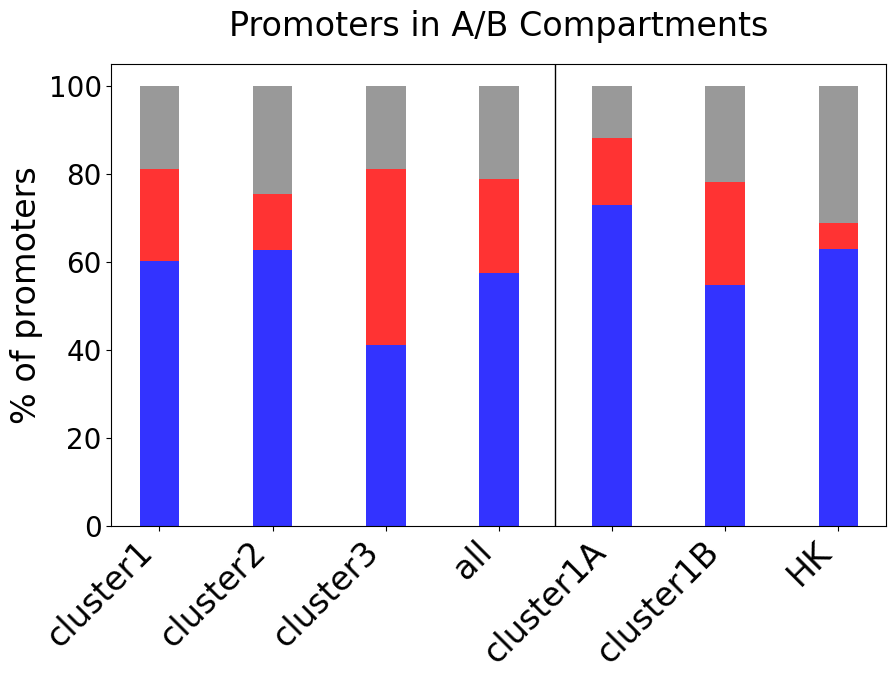

In [ ]:
csv_path = part1_logs + 'compartments_distribution.csv'
read_flag = False
if os.path.exists(csv_path):
    df_comps = pd.read_csv(csv_path)

else:
  # Divide promoters in Compartments
  all_tads = Tad.RetrieveAllTads()
  compA_promoters, compB_promoters, comp_AB_promoters, comp_unassigned_promoters = DividePromotersInCompartments(all_tads)

  # Calculate distribution for each cluster
  clusters = ['cluster1', 'cluster2', 'cluster3', 'all', 'cluster1A', 'cluster1B']
  columns = ['Cluster', 'CompA', 'CompB', 'Unassigned', 'Both']
  df_comps = pd.DataFrame(columns=columns)
  df_comps = CalculateCompartmentsDistribution(df_comps, clusters)

  # Add HK genes compartments
  cluster = 'HK'
  row_dict = {key : 0 for key in columns}
  row_dict['CompA'] = len(set(compA_promoters).intersection(hk_identifiers))
  row_dict['CompB'] = len(set(compB_promoters).intersection(hk_identifiers))
  row_dict['Unassigned'] = len(set(comp_unassigned_promoters).intersection(hk_identifiers))
  total_counts = sum(row_dict.values())
  percentages_dict = {key: value / total_counts for key, value in row_dict.items()}
  formated_dict = {key: float("{:.2f}".format(value * 100)) for key, value in percentages_dict.items()}
  formated_dict['Cluster'] = cluster
  df_comps.loc[len(df_comps)] = formated_dict

  df_comps.to_csv(csv_path, index=False)

def PlotCompartmentsDistribution(df_comps, png_path):

  size = 24
  size_smaller = size - 4

  # Plotting with thinner bars and different colors
  ax = df_comps.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.35,
                    color=['blue', 'red', 'gray'], alpha=0.8, legend=None)
  ax.set_ylabel('% of promoters', fontsize=size)
  ax.set_title('Promoters in A/B Compartments', fontsize=size, pad=20)  # Increase pad for more space between title and figure

  # Remove x-label
  ax.set_xlabel('')
  #plt.legend(loc='upper right', bbox_to_anchor=(1.37, 1), fontsize=size - 4)
  plt.xticks(rotation=45, ha='right')
  plt.yticks(fontsize=size)
  ax.tick_params(axis='x', labelsize=size)  # Adjust x-axis label size here
  ax.tick_params(axis='y', labelsize=size_smaller)  # Adjust x-axis label size here

  # Add horizontal lines
  #for value in [20, 40, 60, 80]:
  #    ax.axhline(y=value, color='black', linestyle='--', linewidth=0.5, alpha=0.6)

  # Add vertical line
  cluster1A_index = df_comps.index.get_loc('cluster1A')

  ax.axvline(x=cluster1A_index - 0.5, color='black', linestyle='-', linewidth=1.0)

  plt.savefig(png_path, bbox_inches='tight')  # Use bbox_inches='tight' to include legend properly
  #plt.savefig(png_path, bbox_inches='tight',  pad_inches=0.25)  # Use bbox_inches='tight' to include legend properly
  plt.show()

# Plot distributions
df_comps = df_comps.drop(columns='Both')
df_comps.set_index('Cluster', inplace=True)
png_path = part1_dir + 'compartments_distribution.png'
PlotCompartmentsDistribution(df_comps, png_path)

**3.2. Distribution of promoters in TADs**

In [ ]:
def CalculateBinsDistribution(promoters, cluster, df):
  #Define counts of promoters in each bin
  total_bin_counts = {f'Bin{i}': 0 for i in range(n_bins + 1)}
  for promoter in promoters:
    # Bins of promoters
    promoter_bins = [value for sublist in promoter.tads.values() for value in sublist]
    # Bins are counted once in the TAD
    unique_bins = list(set(promoter_bins))

    # Bin 0 will only count for once)
    if 'Bin0' in unique_bins:
        total_bin_counts['Bin0'] += 1
    else:
        for bin in unique_bins:
            total_bin_counts[bin] += 1
  # Get total counts
  total_counts = sum(value for value in total_bin_counts.values())
  # Bin percentages
  percentages_dict = {key: value / total_counts for key, value in total_bin_counts.items()}
  formated_dict = {key: float("{:.2f}".format(value * 100)) for key, value in percentages_dict.items()}
  # Save in df
  formated_dict['Cluster'] = cluster
  formated_dict['permutation'] = permutation
  new_row = formated_dict
  df.loc[len(df)] = new_row
  return df

In [ ]:
# Distribution of promoters in the bins of TADs - REAL clusters

csv_path = part1_logs + 'bins_distribution_observed.csv'
permutation = 'Observed'

if os.path.exists(csv_path):
  df_observed = pd.read_csv(csv_path)
else:
  columns = ['permutation', 'Cluster'] + Tad.bins
  df = pd.DataFrame(columns=columns)

  # Cluster1 distribution
  cluster = 'cluster1'
  promoters = Promoter.RetrieveClusterMembers('cluster1A') + Promoter.RetrieveClusterMembers('cluster1B')
  df = CalculateBinsDistribution(promoters, cluster, df)

  # Clusters 1A, 1B, 2, 3 distribution
  for cluster in clusters_dict.keys():
    promoters = Promoter.RetrieveClusterMembers(cluster)
    df = CalculateBinsDistribution(promoters, cluster, df)

  # 'All' promoters distribution
  cluster = 'all'
  promoters = Promoter.RetrieveClusterMembers(cluster)
  df = CalculateBinsDistribution(promoters, cluster, df)

  # HK genes distribution
  cluster = 'HK'
  hk_identifiers = []
  with open(hk_genes_list, 'r') as file:
    for line in file:
      identifier = line.strip('\n')
      hk_identifiers.append(identifier)
  hk_promoters = []
  for identifier, promoter in Promoter.all_promoters.items():
    if identifier in hk_identifiers:
      hk_promoters.append(promoter)
  df = CalculateBinsDistribution(hk_promoters, cluster, df)

  # Make a little modification in column names
  df = df.rename(columns={col: str(i) for i, col in enumerate(df.columns[2:], start=0)})

  df_observed = df.copy()
  df_observed.to_csv(csv_path, index=False)

df_observed

,permutation,Cluster,0,1,2,3,4,5
0,Observed,cluster1,19.13,17.42,16.37,16.78,15.63,14.67
1,Observed,cluster1A,12.20,18.21,17.06,18.06,17.71,16.76
2,Observed,cluster1B,22.12,17.07,16.07,16.23,14.73,13.78
3,Observed,cluster2,24.86,17.24,14.95,14.07,14.19,14.69
4,Observed,cluster3,19.21,16.84,17.55,15.91,14.98,15.52
5,Observed,all,21.37,17.23,16.05,15.56,14.94,14.85
6,Observed,HK,31.61,15.49,13.67,12.76,12.79,13.67


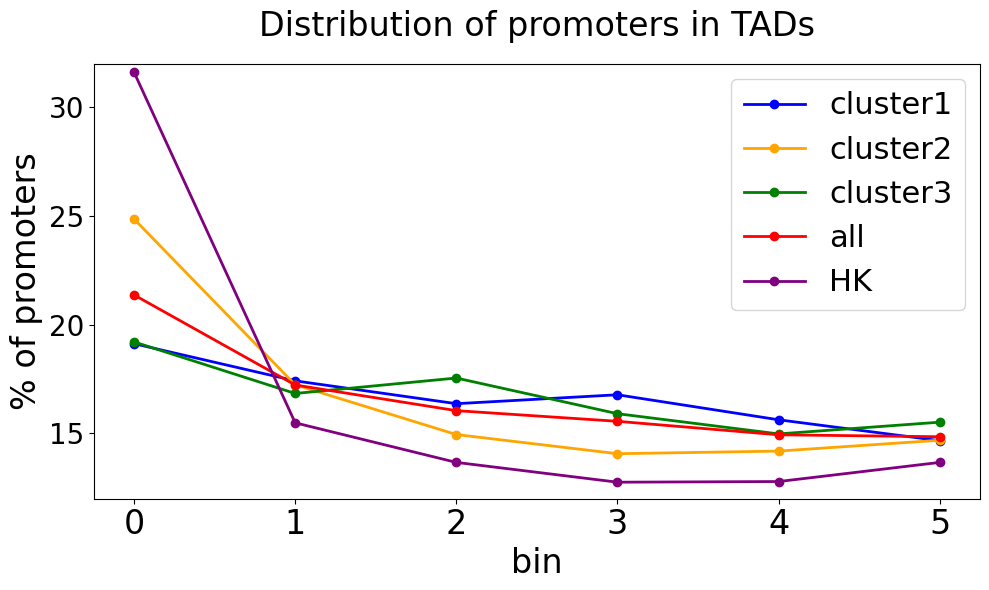

In [ ]:
def PlotBinsDistribution(df, colors, png_path):
    # Plot
    plt.figure(figsize=(10, 6))

    size = 24
    size_smaller = size - 4
    # Plot each cluster
    for index, row in df.iterrows():
        plt.plot(df.columns[2:], row[2:], marker='o', color=colors[row['Cluster']], label=row['Cluster'], linewidth=2, markersize=6)

    # Add labels and legend
    plt.xlabel('bin', fontsize = size)
    plt.ylabel('% of promoters', fontsize = size)
    plt.title('Distribution of promoters in TADs', fontsize=size, pad=20)
    #plt.xticks(rotation=45)
    plt.legend()
    plt.ylim(12, 32)  # Adjust limits as needed
    plt.yticks([15, 20, 25, 30], fontsize=size_smaller)
    plt.xticks(fontsize=size)
    plt.legend(fontsize=size - 2)  # Increase font size of legend

    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(png_path)
    plt.show()

colors = {'cluster1' : 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all' : 'red', 'HK' : 'purple'}
png_path = part1_dir + 'distribution_bins.png'

PlotBinsDistribution(df_observed[(df_observed['Cluster'] != 'cluster1A') & (df_observed['Cluster'] != 'cluster1B')], colors, png_path)

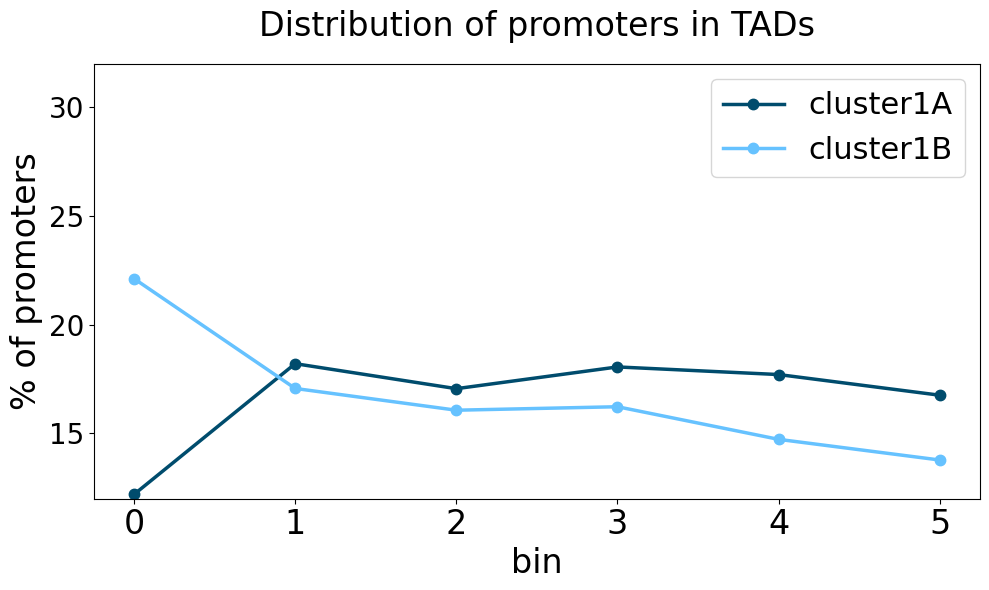

In [ ]:

def PlotBinsDistribution(df, colors, png_path):
    # Plot
    plt.figure(figsize=(10, 6))

    size = 24
    size_smaller = size - 4
    # Plot each cluster
    for index, row in df.iterrows():
        plt.plot(df.columns[2:], row[2:], marker='o', color=colors[row['Cluster']], label=row['Cluster'], linewidth=2.5, markersize=7.5)

    # Add labels and legend
    plt.xlabel('bin', fontsize = size)
    plt.ylabel('% of promoters', fontsize = size)
    plt.title('Distribution of promoters in TADs', fontsize=size,  pad=20)
    #plt.xticks(rotation=45)
    plt.legend()
    plt.ylim(12, 32)  # Adjust limits as needed
    plt.yticks([15, 20, 25, 30], fontsize=size_smaller)
    plt.xticks(fontsize=size)
    plt.legend(fontsize=size - 2)  # Increase font size of legend

    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(png_path)
    plt.show()

png_path = part1_dir + 'distribution_bins_1A_1B.png'

PlotBinsDistribution(df_observed[(df_observed['Cluster'] == 'cluster1A') | (df_observed['Cluster'] == 'cluster1B')], colors, png_path)
#PlotBinsDistribution(df_observed[df_observed['Cluster'] != 'cluster1'], colors, png_path)

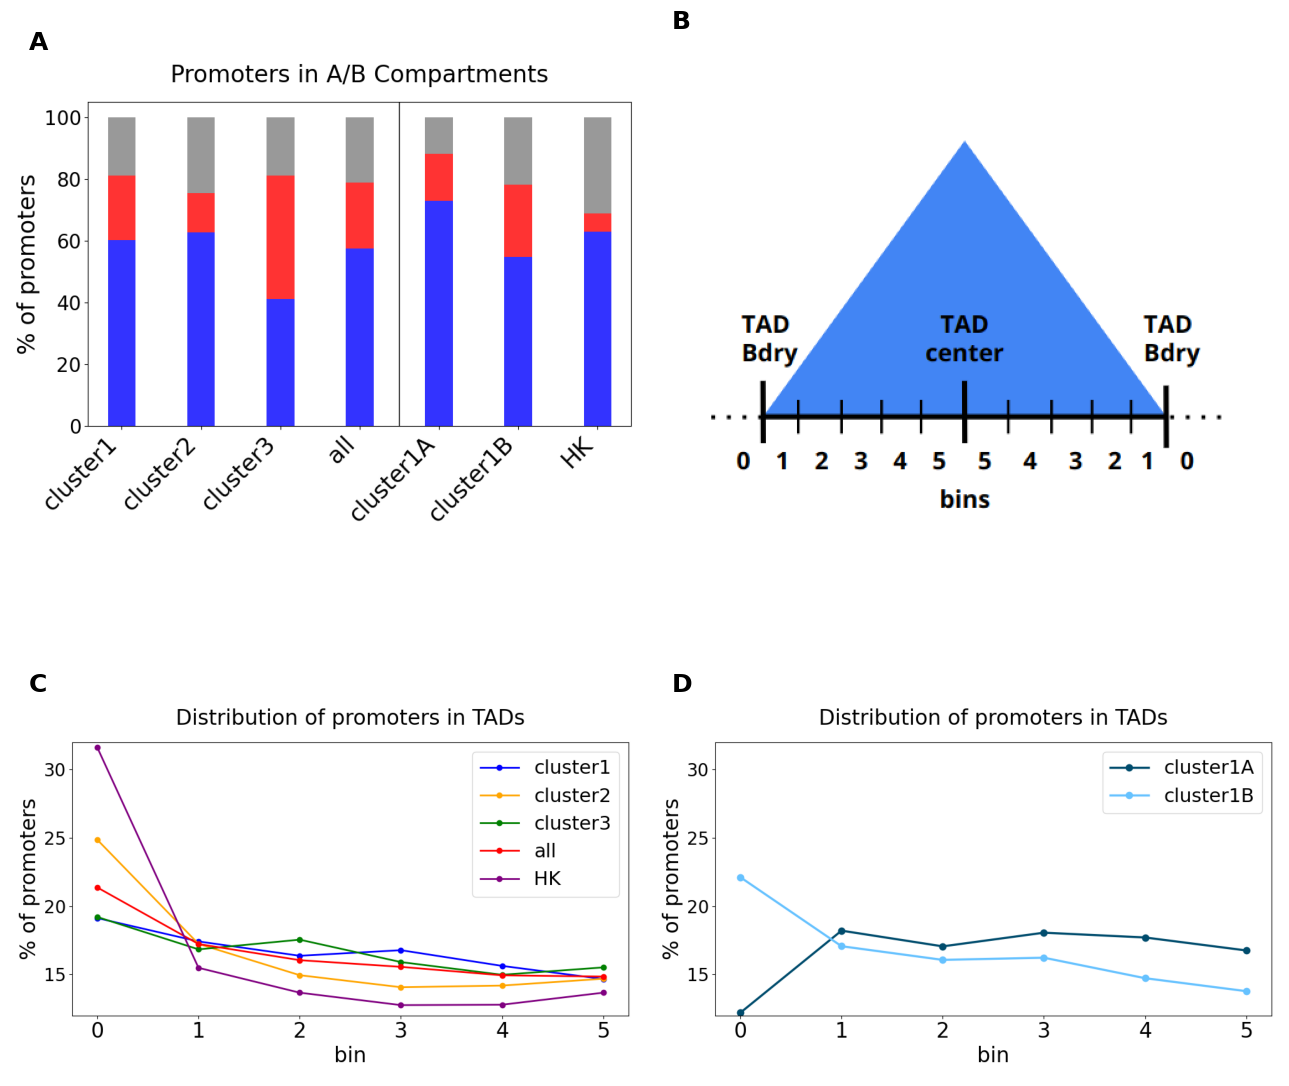

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the three images
image1 = Image.open(part1_dir + 'compartments_distribution.png')
image2 = Image.open(part1_dir + 'Alvaro_bins_adapted.png')
image3 = Image.open(part1_dir + 'distribution_bins.png')
image4 = Image.open(part1_dir + 'distribution_bins_1A_1B.png')

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(13, 13))

# Set titles for each subplot with smaller font size
axs[0, 0].set_title('A', fontsize=18, fontweight='bold', loc='left', x=0.03, y=1.0)
axs[0, 1].set_title('B', fontsize=18, fontweight='bold', loc='left', x=0.03, y=1.0)
axs[1, 0].set_title('C', fontsize=18, fontweight='bold', loc='left', x=0.03, y=1.0)
axs[1, 1].set_title('D', fontsize=18, fontweight='bold', loc='left', x=0.03, y=1.0)

# Display each image in its respective subplot
axs[0, 0].imshow(image1)
#axs[0, 0].imshow(image1)
axs[0, 1].imshow(image2)
axs[1, 0].imshow(image3)
axs[1, 1].imshow(image4)

# Hide axes
for ax in axs.flatten():
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Show the figure

**Perform statistical test with Chi square**

In [ ]:
# Distribution of promoters in the bins of TADs - REAL clusters
def CalculateBinsDistribution(promoters, cluster, df):
  #Define counts of promoters in each bin
  total_bin_counts = {f'Bin{i}': 0 for i in range(n_bins + 1)}
  for promoter in promoters:
    # Bins of promoters
    promoter_bins = [value for sublist in promoter.tads.values() for value in sublist]
    # Bins are counted once in the TAD
    unique_bins = list(set(promoter_bins))

    # Bin 0 will only count for once)
    if 'Bin0' in unique_bins:
        total_bin_counts['Bin0'] += 1
    else:
        for bin in unique_bins:
            total_bin_counts[bin] += 1
  total_bin_counts['Cluster'] = cluster
  new_row = total_bin_counts
  df.loc[len(df)] = new_row
  return df


columns = ['Cluster'] + Tad.bins
df = pd.DataFrame(columns=columns)

# Cluster1 distribution
cluster = 'cluster1'
promoters = Promoter.RetrieveClusterMembers('cluster1A') + Promoter.RetrieveClusterMembers('cluster1B')
df = CalculateBinsDistribution(promoters, cluster, df)

# Clusters 1A, 1B, 2, 3 distribution
for cluster in clusters_dict.keys():
  promoters = Promoter.RetrieveClusterMembers(cluster)
  df = CalculateBinsDistribution(promoters, cluster, df)

# 'All' promoters distribution
cluster = 'all'
promoters = Promoter.RetrieveClusterMembers(cluster)
df = CalculateBinsDistribution(promoters, cluster, df)

# HK genes distribution
cluster = 'HK'
hk_identifiers = []
with open(hk_genes_list, 'r') as file:
  for line in file:
    identifier = line.strip('\n')
    hk_identifiers.append(identifier)
hk_promoters = []
for identifier, promoter in Promoter.all_promoters.items():
  if identifier in hk_identifiers:
    hk_promoters.append(promoter)
df = CalculateBinsDistribution(hk_promoters, cluster, df)

# Make a little modification in column names
#df = df.rename(columns={col: str(i) for i, col in enumerate(df.columns[2:], start=0)})

#df_observed = df.copy()
#df_observed.to_csv(csv_path, index=False)

df

,Cluster,Bin0,Bin1,Bin2,Bin3,Bin4,Bin5
0,cluster1,1661,1512,1421,1457,1357,1274
1,cluster1A,319,476,446,472,463,438
2,cluster1B,1342,1036,975,985,894,836
3,cluster2,2013,1396,1211,1139,1149,1190
4,cluster3,786,689,718,651,613,635
5,all,4460,3597,3350,3247,3119,3099
6,HK,1045,512,452,422,423,452


In [ ]:
import pandas as pd
from itertools import combinations
from scipy.stats import chi2_contingency

# Get all combinations of pairs of groups
group_pairs = list(combinations(df['Cluster'], 2))

# Perform tests for each pair
columns = ['clusterA', 'clusterB', 'chi_statistic', 'pval']
df_pvals = pd.DataFrame(columns=columns)

for pair in group_pairs:
    group1_name, group2_name = pair
    new_row = {}
    new_row['clusterA'] = group1_name
    new_row['clusterB'] = group2_name

    group1_data = df[df['Cluster'] == group1_name].drop(columns='Cluster').values.flatten()
    group2_data = df[df['Cluster'] == group2_name].drop(columns='Cluster').values.flatten()

    # Chi-square test
    chi2_stat, p_value, _, _ = chi2_contingency([group1_data, group2_data])
    new_row['chi_statistic'] = chi2_stat
    new_row['pval'] = p_value
    df_pvals.loc[len(df_pvals)] = new_row

df_pvals

,clusterA,clusterB,chi_statistic,pval
0,cluster1,cluster1A,69.385819,1.375385e-13
1,cluster1,cluster1B,20.607049,9.608612e-04
2,cluster1,cluster2,93.977366,9.799786e-19
3,cluster1,cluster3,6.227209,2.847341e-01
4,cluster1,all,23.126135,3.193283e-04
5,cluster1,HK,220.829314,9.869930e-46
6,cluster1A,cluster1B,121.333207,1.637986e-24
7,cluster1A,cluster2,194.860489,3.569899e-40
8,cluster1A,cluster3,62.779059,3.234633e-12
9,cluster1A,all,125.101787,2.603626e-25


In [ ]:
def transform_value(value):
    if value < 0.005:
        return '***'
    elif value < 0.01:
        return '**'
    elif value < 0.05:
        return '*'
    else:
        return '.'
df_symbols = df_pvals.copy()

# Apply the function to each value in the DataFrame
df_symbols['pval'] = df_symbols['pval'].apply(transform_value)


filtered_df = df_symbols[(df_symbols['clusterA'] == 'all') | (df_symbols['clusterB'] == 'all')]
filtered_df
# cluster1B - all no significativo
# cluster 3 - all *
# cluster1, cluster2, cluster1B - all ***

,clusterA,clusterB,chi_statistic,pval
4,cluster1,all,23.126135,***
9,cluster1A,all,125.101787,***
13,cluster1B,all,6.486870,.
16,cluster2,all,47.169699,***
18,cluster3,all,13.912547,*
20,all,HK,173.182945,***


However, the chi-square test alone doesn't tell you which categories are driving the association. To understand which categories contribute to the significant association, you can inspect the residuals. Residuals are the differences between observed and expected counts in each cell of the contingency table. Large positive residuals suggest over-representation of a category, while large negative residuals suggest under-representation.

In [ ]:
#filtered_df = df[~df['Cluster'].isin(['cluster1A', 'cluster1B', 'all'])]
filtered_df = df.copy()
group_pairs = list(combinations(filtered_df['Cluster'], 2))

# Perform tests for each pair
for pair in group_pairs:
    group1_name, group2_name = pair
    group1_data = filtered_df[filtered_df['Cluster'] == group1_name].drop(columns='Cluster').values.flatten()
    group2_data = filtered_df[filtered_df['Cluster'] == group2_name].drop(columns='Cluster').values.flatten()

    # Chi-square test
    chi2_stat, p_value, _, _ = chi2_contingency([group1_data, group2_data])

    # Calculate expected counts
    expected_counts = pd.DataFrame(_)

    # Calculate residuals
    residuals = (pd.DataFrame([group1_data, group2_data]) - expected_counts) / np.sqrt(expected_counts)

    if group1_name == 'all' or group2_name == 'all':
      print(f"Comparison between {group1_name} and {group2_name}:")
#    print("Chi-square Statistic:", chi2_stat)
      print("P-value:", p_value)
      print("\nResiduals:")
      print(residuals)
      print()

      # Los residuals parecen indicar que las diferencias observdas se deben a Bin0 y luego puede haber alguno a Bins de dentro.

Comparison between cluster1 and all:
P-value: 0.00031932832861430007

Residuals:
          0         1         2         3         4         5
0 -3.234317  0.287620  0.519159  2.020743  1.160936 -0.296987
1  2.085981 -0.185501 -0.334833 -1.303284 -0.748749  0.191542

Comparison between cluster1A and all:
P-value: 2.6036259565798073e-25

Residuals:
          0         1         2         3         4         5
0 -9.231405  1.064919  1.143479  2.854437  3.221436  2.234284
1  3.266920 -0.376866 -0.404668 -1.010162 -1.140040 -0.790695

Comparison between cluster1B and all:
P-value: 0.2616823766377807

Residuals:
         0         1         2         3         4         5
0  0.97233 -0.233496  0.026640  1.029301 -0.329064 -1.690373
1 -0.52427  0.125898 -0.014364 -0.554987  0.177427  0.911430

Comparison between cluster2 and all:
P-value: 5.246395017179721e-09

Residuals:
          0         1         2         3         4         5
0  4.786386  0.008136 -1.790688 -2.485278 -1.274925 -0.2572

Given that the residuals for 'Bin0' are large and positive for the first group and large and negative for the second group, this suggests that 'Bin0' is the one making the most difference between the two groups. PARA EL EJEMPLO 1.

Randomize with cluster1A and cluster1B

In [ ]:
# Calculate dataframe with ARTIFICIAL clusters: PERMUTED statistic

cluster_sizes = {'cluster1A': 2581, 'cluster1B': 6001, 'cluster2': 7988, 'cluster3': 4049}
n_permutations = 1000

csv_path = part1_logs + 'bins_distribution_permuted.csv'
read_flag = True

if os.path.exists(csv_path) and read_flag:
  df_permuted = pd.read_csv(csv_path)
else:

  # Calculate permutations for cluster1A, cluster1B, cluster2, cluster3
  df_permuted1 = pd.DataFrame(columns=columns)
  for permutation in range(n_permutations):
    # Create random clusters
    Promoter.CreateRandomClusters(cluster_sizes)
    # Calculate bins distribution for each cluster
    for cluster in clusters_dict.keys():
      promoters = Promoter.RetrieveClusterMembers(cluster)
      df_permuted1 = CalculateBinsDistribution(promoters, cluster, df_permuted1)

  # Calculate permutations for cluster 1
  cluster_sizes = {'cluster1': 8582, 'cluster2': 7988, 'cluster3': 4049}
  df_permuted2 = pd.DataFrame(columns=columns)
  for permutation in range(n_permutations):
      # Create random clusters
      Promoter.CreateRandomClusters(cluster_sizes)
      # Calculate bins distribution for each cluster
      for cluster in cluster_sizes.keys():
        promoters = Promoter.RetrieveClusterMembers(cluster)
        df_permuted2 = CalculateBinsDistribution(promoters, cluster, df_permuted2)
  categorical_df = df_permuted2[df_permuted2['Cluster'] == 'cluster1']

  # Concatenate both dataframes
  df_permuted = pd.concat([df_permuted1, categorical_df], axis=0, ignore_index=True)

  # Save as csv
  df_permuted.to_csv(csv_path, index=False)

df_permuted

,permutation,Cluster,Bin0,Bin1,Bin2,Bin3,Bin4,Bin5
0,0,cluster1A,21.46,17.16,15.97,15.55,14.91,14.94
1,0,cluster1B,20.38,17.35,16.44,16.00,15.14,14.68
2,0,cluster2,21.45,17.03,16.52,15.25,14.80,14.95
3,0,cluster3,22.61,17.52,14.58,15.51,14.95,14.83
4,1,cluster1A,20.70,16.91,17.48,15.57,13.93,15.42
...,...,...,...,...,...,...,...,...
4995,995,cluster1,21.55,16.72,16.29,15.81,14.90,14.74
4996,996,cluster1,20.98,17.83,15.66,15.01,15.44,15.08
4997,997,cluster1,21.08,17.61,16.31,15.19,15.02,14.79
4998,998,cluster1,21.18,17.59,15.88,15.98,14.97,14.40


In [ ]:
# Calculate p-values

csv_path = part1_logs + 'bins_distribution_pvalues.csv'
read_flag = False

if os.path.exists(csv_path) and read_flag:
    df_pvalues = pd.read_csv(csv_path)
else:
  columns = ['Cluster', 'Bin0', 'Bin1', 'Bin2', 'Bin3', 'Bin4', 'Bin5']
  df_pvalues = pd.DataFrame(columns=columns)

  for cluster in ['cluster1', 'cluster1A', 'cluster1B', 'cluster2', 'cluster3']:

    new_row = {key : 0 for key in columns}
    new_row['Cluster'] = cluster
    # Obtain dataframe for cluster
    categorical_df = df_permuted[df_permuted['Cluster'] == cluster]

    # Convert columns to array
    for column in df_permuted.columns[2:]:
      permuted_data = categorical_df[column].values
      mu, std = np.mean(permuted_data), np.std(permuted_data)

      # Create a normal distribution using the estimated parameters
      normal_dist = norm(loc=mu, scale=std)

      # Kolmogorov-Smirnov test for goodness of fit of our data to a normal distributionn
      statistic, p_value = kstest(permuted_data, normal_dist.cdf)

      #If the p-value is high (e.g., greater than 0.05), it suggests that the data is likely to be drawn from the normal distribution.
      if p_value < 0.05:
        print("Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data:", cluster, column, statistic, p_value)

      # Once we know that it follows a normal distribution, we calculate probability of the observed value
      observed_value = df_observed.loc[df_observed['Cluster'] == cluster, column.strip('Bin')].iloc[0]
      pdf_at_obs = normal_dist.pdf(observed_value) # p-value or probability of finding the value in the random distribution

      new_row[column] = pdf_at_obs

    df_pvalues.loc[len(df_pvalues)] = new_row
  df_pvalues.to_csv(csv_path, index=False)

df_pvalues

,Cluster,Bin0,Bin1,Bin2,Bin3,Bin4,Bin5
0,cluster1,2.867177e-10,1.048280,0.772801,0.000433,0.098265,1.177438
1,cluster1A,2.692888e-32,0.219972,0.174179,0.000493,0.000055,0.006898
2,cluster1B,2.219634e-01,0.906897,1.023508,0.266249,0.894467,0.023149
3,cluster2,4.400467e-21,1.236181,0.002398,0.000028,0.060075,1.165056
4,cluster3,4.095606e-04,0.577996,0.010143,0.612765,0.813065,0.327188


In [ ]:
def transform_value(value):
    if value < 0.005:
        return '***'
    elif value < 0.01:
        return '**'
    elif value < 0.05:
        return '*'
    else:
        return '.'
csv_path =  part1_dir + 'bins_distribution_significance_greater.csv'
df_symbols = df_pvalues.copy()

# Apply the function to each value in the DataFrame
for col in df_symbols.columns[1:]:
    df_symbols[col] = df_symbols[col].apply(transform_value)
    df_symbols.to_csv(csv_path)

df_symbols

,Cluster,Bin0,Bin1,Bin2,Bin3,Bin4,Bin5
0,cluster1,***,.,.,***,.,.
1,cluster1A,***,.,.,***,***,**
2,cluster1B,.,.,.,.,.,*
3,cluster2,***,.,***,***,.,.
4,cluster3,***,.,*,.,.,.


In [ ]:
# Assuming df_permuted and df_observed are already defined

csv_path = part1_logs + 'bins_distribution_distributions.csv'
read_flag = False

if os.path.exists(csv_path) and read_flag:
    df_distributions = pd.read_csv(csv_path)
else:
    columns = ['Cluster', 'Bin0', 'Bin1', 'Bin2', 'Bin3', 'Bin4', 'Bin5']
    df_distributions = pd.DataFrame(columns=columns)

    for cluster in ['cluster1', 'cluster1A', 'cluster1B', 'cluster2', 'cluster3']:
        new_row = {key : 0 for key in columns}
        new_row['Cluster'] = cluster
        # Obtain dataframe for cluster
        categorical_df = df_permuted[df_permuted['Cluster'] == cluster]

        # Convert columns to array*
        for column in df_permuted.columns[2:]:
          permuted = categorical_df[column].values
          new_row[column] = permuted

        df_distributions.loc[len(df_distributions)] = new_row
    df_distributions.to_csv(csv_path, index=False)

df_distributions

,Cluster,Bin0,Bin1,Bin2,Bin3,Bin4,Bin5
0,cluster1,"[21.22, 21.83, 21.81, 21.26, 20.86, 21.48, 21....","[17.93, 17.28, 16.04, 17.28, 17.0, 17.24, 16.6...","[15.64, 15.54, 16.47, 15.99, 16.27, 16.15, 16....","[15.16, 15.69, 15.72, 15.67, 15.58, 15.53, 15....","[15.04, 14.87, 14.95, 14.99, 15.36, 15.05, 14....","[15.0, 14.79, 15.01, 14.81, 14.93, 14.55, 14.9..."
1,cluster1A,"[21.46, 20.7, 21.7, 20.91, 21.3, 22.45, 22.23,...","[17.16, 16.91, 18.07, 18.8, 18.46, 16.3, 16.47...","[15.97, 17.48, 15.71, 16.11, 15.66, 16.76, 15....","[15.55, 15.57, 14.9, 15.11, 14.47, 15.43, 16.4...","[14.91, 13.93, 14.94, 14.77, 15.0, 14.51, 14.8...","[14.94, 15.42, 14.67, 14.31, 15.12, 14.55, 14...."
2,cluster1B,"[20.38, 21.77, 21.65, 21.55, 21.77, 21.65, 20....","[17.35, 17.49, 16.75, 17.27, 17.25, 17.19, 16....","[16.44, 15.75, 16.39, 15.54, 15.81, 15.82, 16....","[16.0, 15.73, 15.32, 15.59, 15.04, 15.46, 15.7...","[15.14, 14.76, 15.07, 14.69, 14.96, 15.16, 15....","[14.68, 14.51, 14.81, 15.35, 15.17, 14.72, 15...."
3,cluster2,"[21.45, 20.97, 21.15, 21.75, 21.05, 20.93, 21....","[17.03, 17.14, 17.12, 16.94, 17.28, 17.06, 17....","[16.52, 15.99, 16.03, 15.77, 16.16, 16.2, 16.4...","[15.25, 15.32, 16.07, 15.69, 16.23, 16.09, 14....","[14.8, 15.53, 14.83, 15.28, 14.47, 14.65, 14.5...","[14.95, 15.04, 14.79, 14.57, 14.81, 15.06, 14...."
4,cluster3,"[22.61, 21.99, 21.16, 20.63, 21.44, 21.12, 21....","[17.52, 17.24, 17.63, 16.76, 16.35, 18.23, 17....","[14.58, 15.7, 15.8, 17.32, 16.44, 15.64, 15.54...","[15.51, 15.75, 15.32, 15.52, 15.69, 14.73, 15....","[14.95, 14.7, 14.97, 14.77, 15.81, 15.47, 15.5...","[14.83, 14.61, 15.12, 15.01, 14.27, 14.81, 14...."


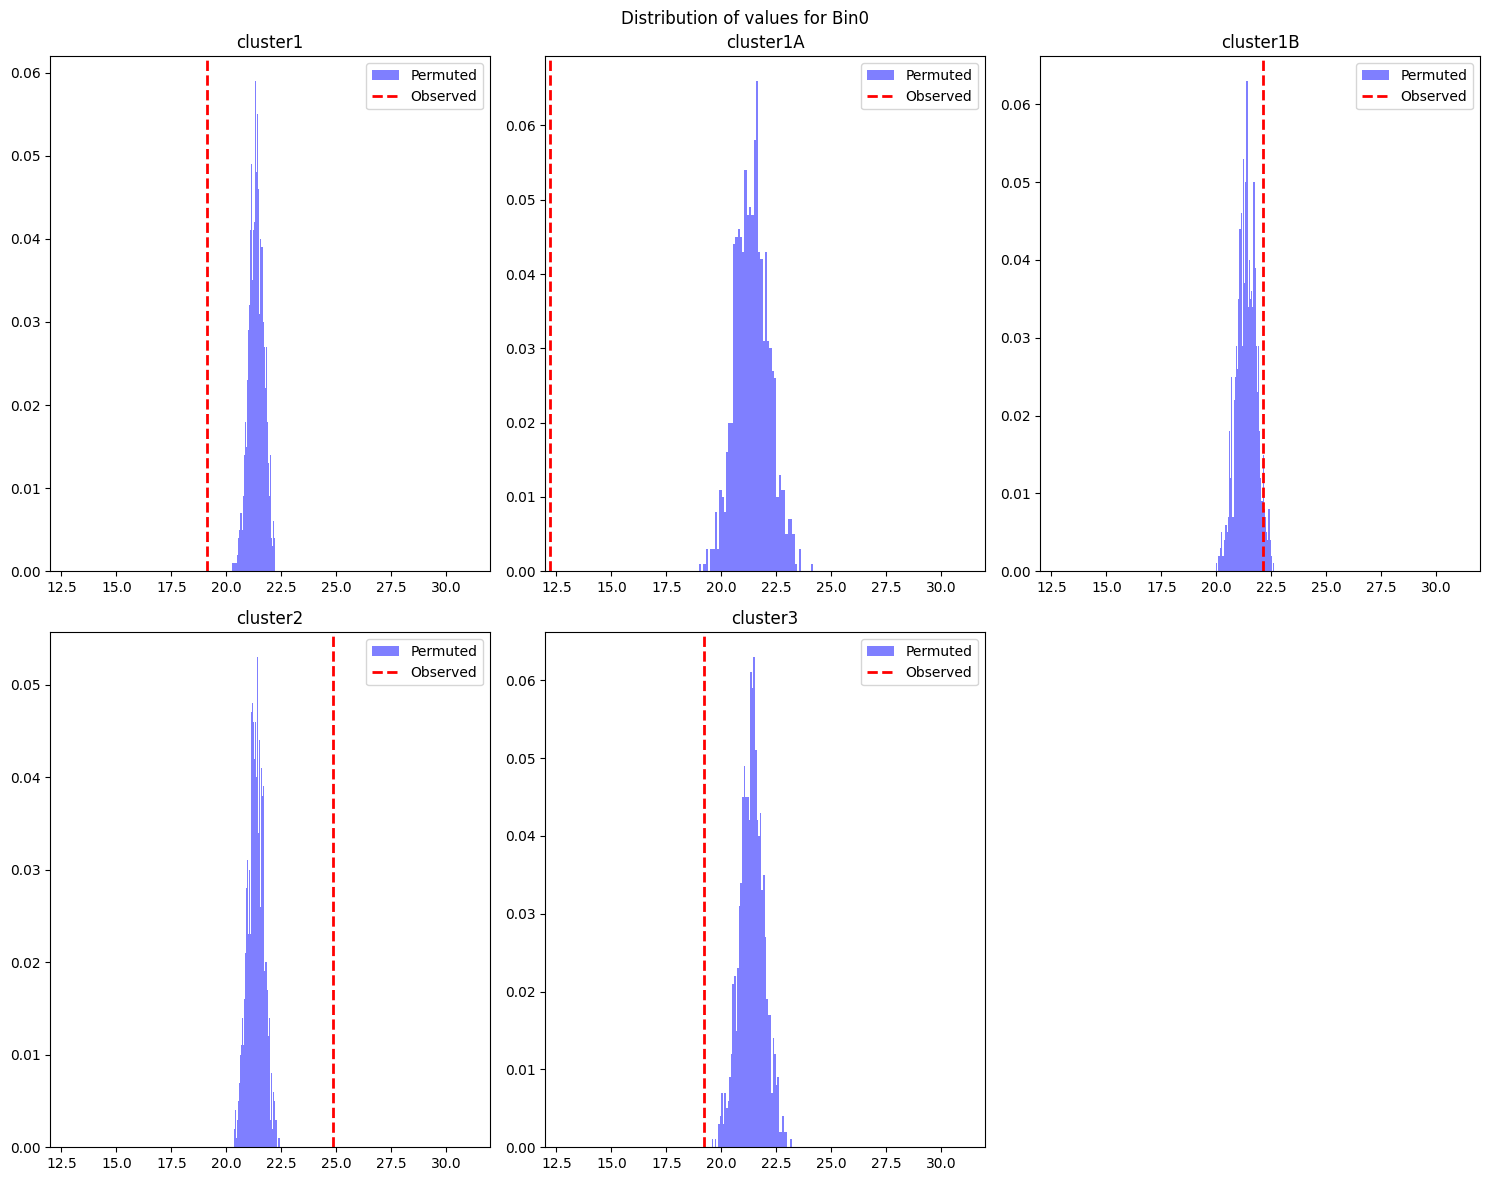

In [ ]:
def plot_distributions(column_name, png_path):
    plt.figure(figsize=(15, 12))
    for i, row in df_distributions.iterrows():
        cluster = row["Cluster"]
        plt.subplot(2, 3, i+1)
        values = row[column_name]
        weights = np.ones_like(values) / len(values)
        plt.hist(values, bins=50, weights=weights, alpha=0.5, label='Permuted', color='blue')
        observed_col_name = column_name.strip('Bin')
        observed_value = df_observed.loc[df_observed['Cluster'] == cluster, observed_col_name].iloc[0]
        plt.axvline(x=observed_value, color='red', linestyle='dashed', linewidth=2, label='Observed')
        plt.title(cluster)
        plt.legend()
        #plt.ylim(0.0, 0.5)
        plt.xlim(12, 32)

    # Set super title
    plt.suptitle(f'Distribution of values for {column_name}')

    plt.tight_layout()
    plt.savefig(png_path)
    plt.show()

png_path = part1_logs + 'Values_distribution_bin0.png'
plot_distributions('Bin0', png_path)


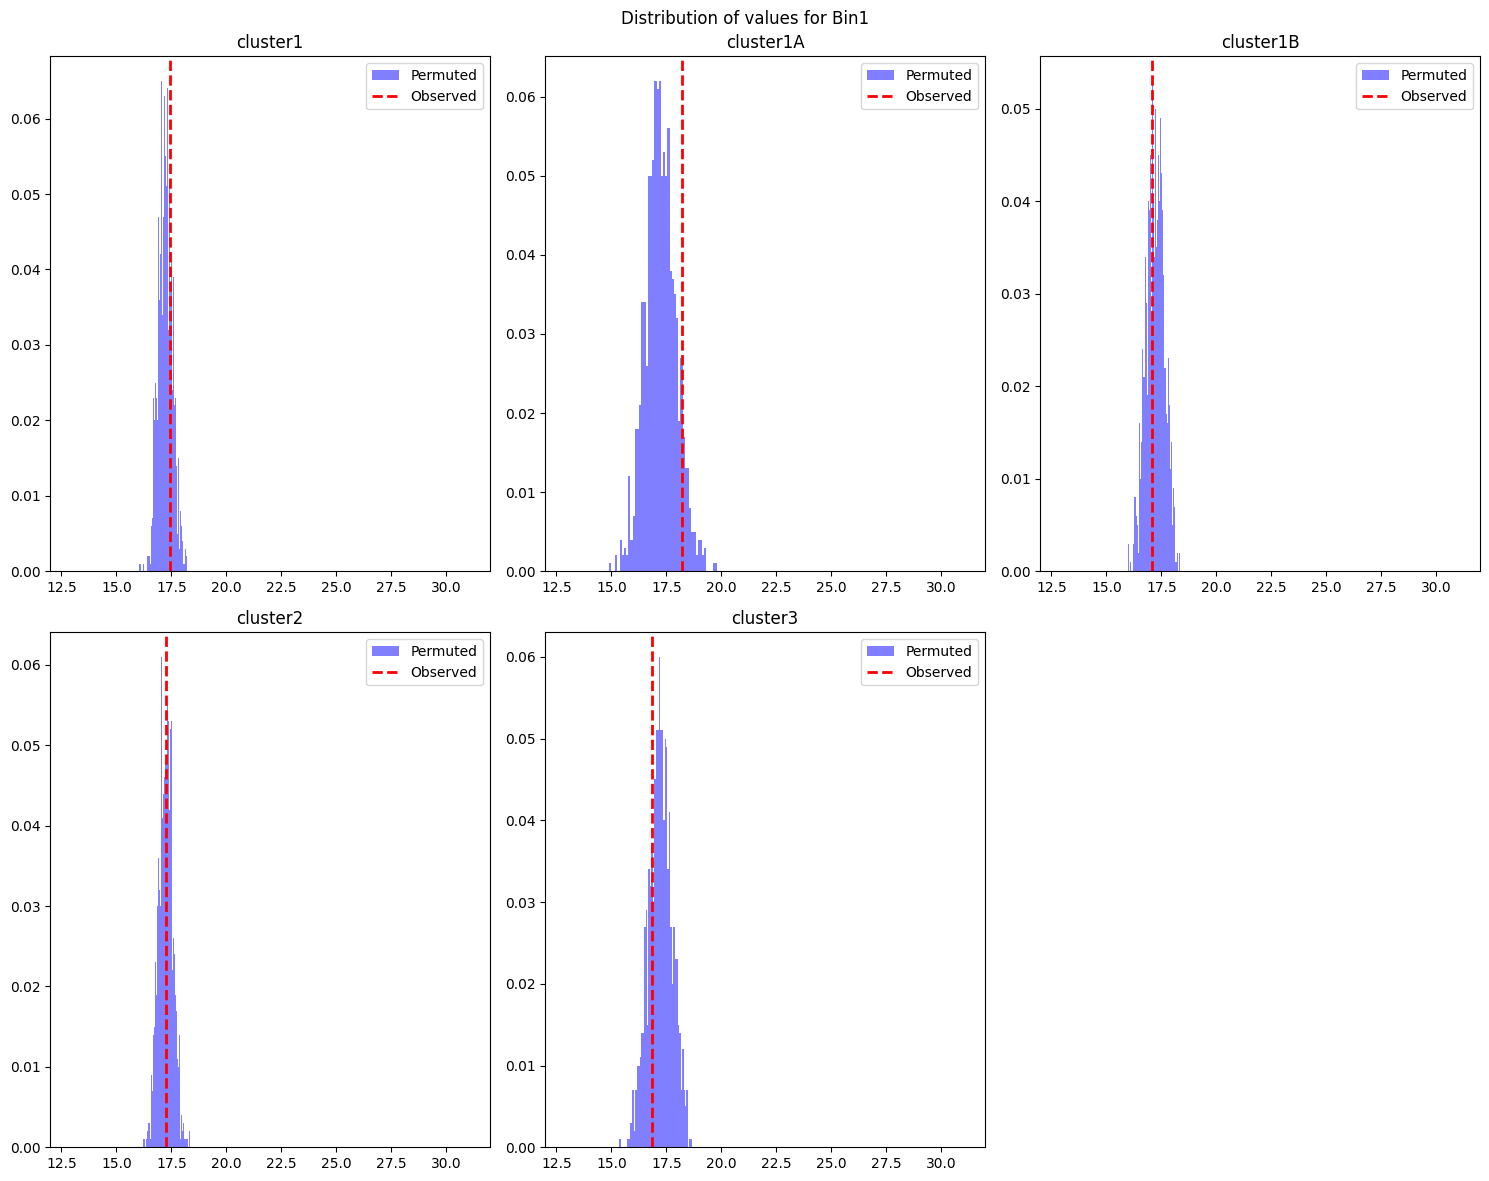

In [ ]:
png_path = part1_logs + 'Values_distribution_bin1.png'

plot_distributions('Bin1', png_path)

**3.3 Caracterization of TADs**

In [ ]:
# Categorize TADs in DENISTY
Tad.CategorizeInDensities()

# Calculate TAD SPÈCIFICITY for each cluster
clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
Tad.CalculateSpecificities(clusters)

**3.3.1. Density in LD, MD and HD**

In [ ]:
def CalculateDensityDistribution(df_dens, clusters):
  inter_tad = {'Bin0': ['Bin0']}

  for cluster in clusters:
    # Retrieve promoters from that cluster
    if cluster == 'cluster1':
      promoters = Promoter.RetrieveClusterMembers('cluster1A') + Promoter.RetrieveClusterMembers('cluster1B')
    else:
      promoters = Promoter.RetrieveClusterMembers(cluster)
    # Exclude promoters in inter-TAD regions
    promoters_in_tads = [prom for prom in promoters if prom.tads != inter_tad]
    # Count densities
    density_counts = {'cluster': 0,'LD': 0, 'MD': 0, 'HD': 0}
    for prom in promoters_in_tads:
      tad = next(iter(prom.tads))
      density_counts[tad.promoters_density[1]] += 1
    total = sum(density_counts.values())
    density_freqs = {key: count / total for key, count in density_counts.items()}
    density_freqs = {key: count / total for key, count in density_counts.items()}
    formated_dict = {key: float("{:.2f}".format(value * 100)) for key, value in density_freqs.items()}
    formated_dict['cluster'] = cluster
    df_dens.loc[len(df_dens)] = formated_dict

  return df_dens

def PlotDensitiesDistribution(df_dens, png_path):
    ax = df_dens.plot(kind='barh', stacked=True, figsize=(10, 6), width=0.4,
                      color=['#1f77b4', '#ff7f0e', '#2ca02c'])

    ax.set_title('Density of TADs')
    ax.set_xlabel('% of promoters', fontsize=12)
    ax.set_ylabel('')
    plt.yticks(rotation=45, ha='right')
    ax.tick_params(axis='y', labelsize=12)
    plt.xticks(fontsize=12)
    plt.legend(title='Density Label', loc='upper right')
    plt.legend(loc='upper right', bbox_to_anchor=(1.23, 1), fontsize=12)

    # Add horizontal lines
    for value in [10.23, 36.50]:
        ax.axvline(x=value, color='red', linestyle='--', linewidth=0.7, alpha=0.7)

    # Save and show plot
    plt.savefig(png_path)
    plt.show()

In [ ]:
# Calculate percentages of genes in each TAD density, only for genes inside a TAD
csv_path = part1_logs + 'densities_distribution.csv'
columns = ['cluster', 'LD', 'MD', 'HD']
#clusters = ['cluster1', 'cluster2', 'cluster3',  'cluster1A', 'cluster1B', 'all']
clusters = ['all', 'cluster1B', 'cluster1A', 'cluster3', 'cluster2', 'cluster1']
read_flag = False

if os.path.exists(csv_path) and read_flag:
    df_dens = pd.read_csv(csv_path)
else:
    df_dens = pd.DataFrame(columns=columns)
    df_dens = CalculateDensityDistribution(df_dens, clusters)
    df_dens.to_csv(csv_path, index=False)

df_dens

,cluster,LD,MD,HD
0,all,10.23,26.27,63.50
1,cluster1B,10.91,29.54,59.55
2,cluster1A,15.02,30.87,54.12
3,cluster3,12.73,23.41,63.87
4,cluster2,6.54,23.55,69.91
5,cluster1,12.25,29.97,57.78


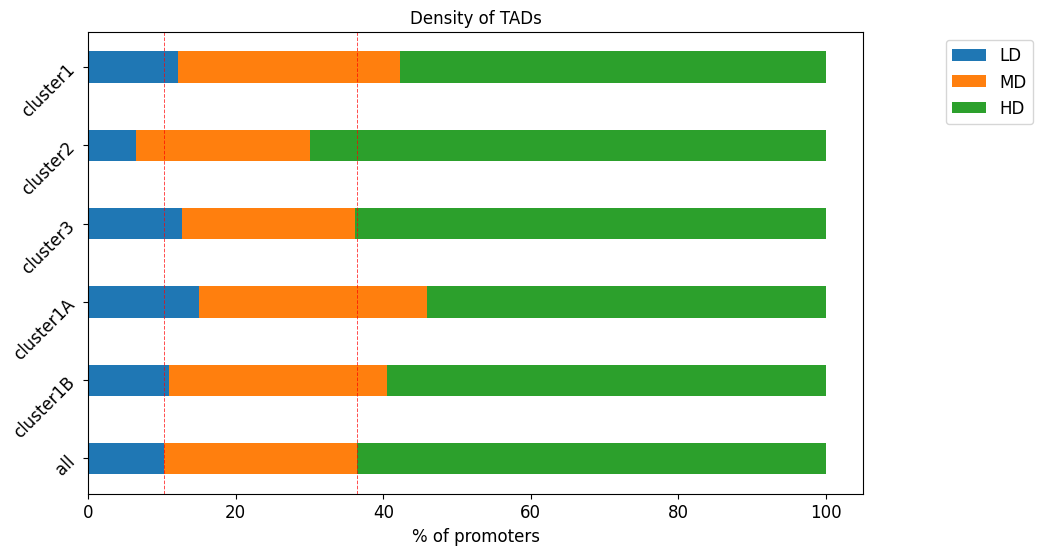

In [ ]:
png_path = part1_dir + 'density_distribution.png'
df_dens.set_index('cluster', inplace=True)
PlotDensitiesDistribution(df_dens, png_path)

**3.3.2. Density, Specificity and Size in ranges from 0.0 to 1.0**

In [ ]:
clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
csv_path = part1_logs + 'promoters_in_tads.csv'

read_flag = True

if os.path.exists(csv_path) and read_flag:
  df_proms = pd.read_csv(csv_path)
else:
  columns = ['promoter', 'Cluster', 'TAD_identifier', 'length', 'n_promoters', 'density_val', 'density_label'] + clusters
  df_proms = pd.DataFrame(columns=columns)

  all_promoters = Promoter.all_promoters.values()
  for prom in all_promoters:
    tad = next(iter(prom.tads)) # tad_instance : ['Bin1', 'Bin2'], 'Bin0':[]'Bin0'] or tad_instance : 'Bin0'
    if tad == 'Bin0': # inter-TAD
      new_row = {'promoter' : prom.identifier,
            'Cluster' : prom.cluster,
            'TAD_identifier': 'Inter-TAD',
            'length': None,
            'n_promoters': None,
            'density_val': None,
            'density_label': None,
            'cluster1A': None,
            'cluster1B': None,
            'cluster2': None,
            'cluster3': None}
    else: # tad_instance : 'Bin0' is considered as to be in that tad
      new_row = {'promoter' : prom.identifier,
                'Cluster' : prom.cluster,
                'TAD_identifier': tad.identifier,
                'length': tad.length,
                'n_promoters': len(tad.RetrievePromoters()),
                'density_val': tad.promoters_density[0],
                'density_label': tad.promoters_density[1],
                'cluster1A': tad.specificity['cluster1A'],
                'cluster1B': tad.specificity['cluster1B'],
                'cluster2': tad.specificity['cluster2'],
                'cluster3': tad.specificity['cluster3']}

    df_proms.loc[len(df_proms)] = new_row
  df_proms.to_csv(csv_path, index=False)
df_proms

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1A,cluster1B,cluster2,cluster3
0,Xkr4,cluster1A,TAD0-4328000,4.328000,1.0,0.231054,LD,1.000000,0.000000,0.000000,0.000000
1,Fam150a,cluster1A,TAD5089000-6980000,1.891000,5.0,2.644104,LD,0.200000,0.600000,0.200000,0.000000
2,Sntg1,cluster1A,TAD7003000-9437000,2.434000,2.0,0.821693,LD,0.500000,0.000000,0.000000,0.500000
3,Sgk3,cluster1A,TAD9559000-10112000,0.553000,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
4,Tcf24,cluster1A,TAD9559000-10112000,0.553000,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
...,...,...,...,...,...,...,...,...,...,...,...
20614,Ssty2,cluster3,TAD9905000-91744698,81.839698,21.0,0.256599,LD,0.000000,0.047619,0.380952,0.571429
20615,Gm20816,cluster3,TAD9905000-91744698,81.839698,21.0,0.256599,LD,0.000000,0.047619,0.380952,0.571429
20616,Gm20806,cluster3,TAD9905000-91744698,81.839698,21.0,0.256599,LD,0.000000,0.047619,0.380952,0.571429
20617,Gm20917,cluster3,TAD9905000-91744698,81.839698,21.0,0.256599,LD,0.000000,0.047619,0.380952,0.571429


In [ ]:
unique_tad_identifiers = df_proms['TAD_identifier'].nunique()
print(f"Number of unique TAD identifiers: {unique_tad_identifiers}")

Number of unique TAD identifiers: 2526


In [ ]:
# Delete promoters not in TADs
df_proms = df_proms[df_proms['TAD_identifier'] != 'Inter-TAD']

unique_tad_identifiers = df_proms['TAD_identifier'].nunique()
print(f"Number of unique TAD identifiers: {unique_tad_identifiers}")

# Delete a huge TAD
df_proms = df_proms[df_proms['length'] < 8]
df_proms

Number of unique TAD identifiers: 2525


,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1A,cluster1B,cluster2,cluster3
0,Xkr4,cluster1A,TAD0-4328000,4.328,1.0,0.231054,LD,1.000000,0.000000,0.000000,0.000000
1,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.200000,0.600000,0.200000,0.000000
2,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.500000,0.000000,0.000000,0.500000
3,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
4,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
...,...,...,...,...,...,...,...,...,...,...,...
20602,Gm6026,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20603,Sry,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20604,Gm16501,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20605,Gm20826,cluster3,TAD6792000-9788000,2.996,2.0,0.667557,LD,0.000000,0.000000,0.000000,1.000000


In [ ]:
cluster_counts = df_proms['Cluster'].value_counts()
print(cluster_counts)

Cluster
cluster2     6001
cluster1B    4655
cluster3     3240
cluster1A    2270
Name: count, dtype: int64


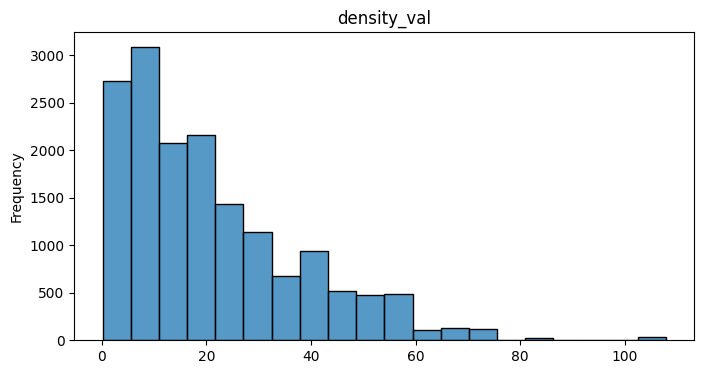

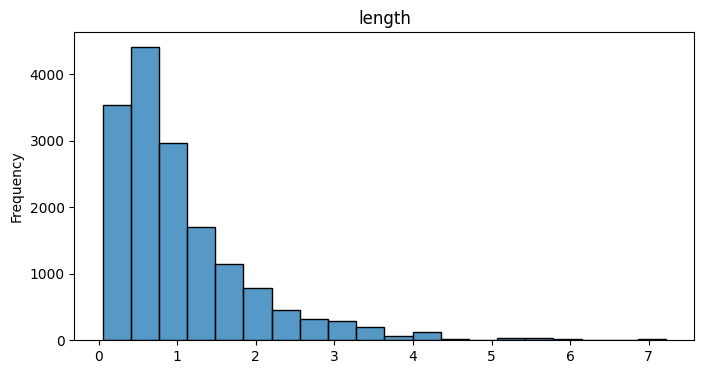

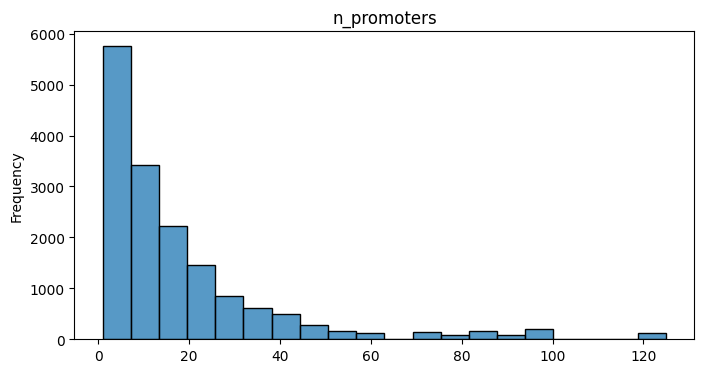

In [ ]:
# Distribution of values: length, n_promoters and density
columns = ['density_val', 'length', 'n_promoters']
for column in columns:
  plt.figure(figsize=(8, 4))
  sns.histplot(data=df_proms, x=column, bins=20, kde=False)
  plt.title(f'{column}')
  plt.xlabel('')
  plt.ylabel('Frequency')
  plt.show()

In [ ]:
# Delete TADs with length lower than 4.000 kb: 300 rows lost
df_proms = df_proms[df_proms['length'] < 3.5]

# Delete TADs with density val lower than 0.00006
df_proms = df_proms[df_proms['density_val'] < 70]

df_proms

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1A,cluster1B,cluster2,cluster3
1,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.200000,0.600000,0.200000,0.000000
2,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.500000,0.000000,0.000000,0.500000
3,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
4,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
6,Slco5a1,cluster1A,TAD12862000-13656000,0.794,4.0,5.037783,MD,0.250000,0.250000,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20602,Gm6026,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20603,Sry,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20604,Gm16501,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20605,Gm20826,cluster3,TAD6792000-9788000,2.996,2.0,0.667557,LD,0.000000,0.000000,0.000000,1.000000


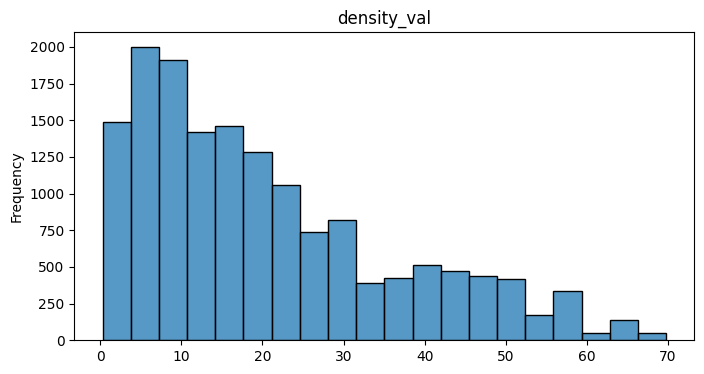

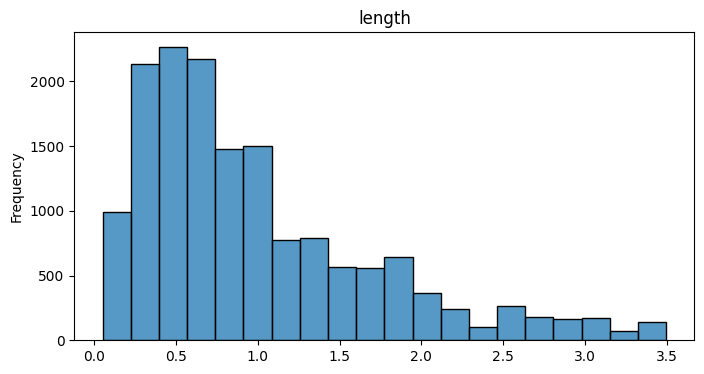

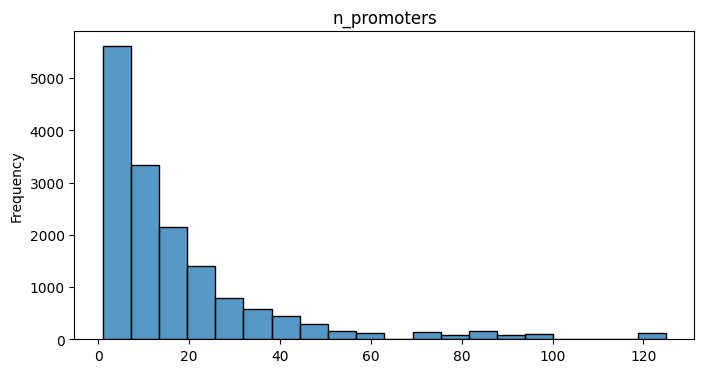

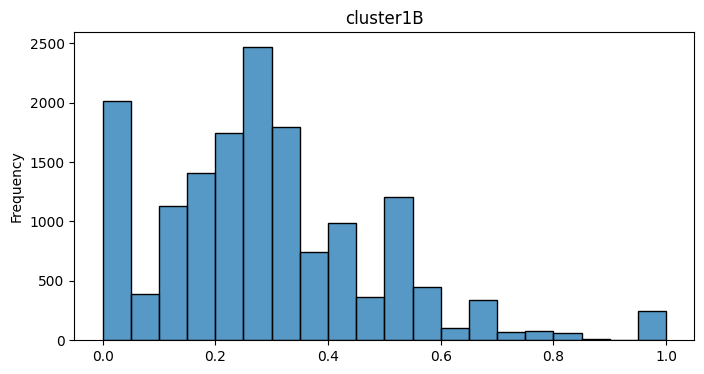

In [ ]:
# Distribution of values: length, n_promoters and density
columns = ['density_val', 'length', 'n_promoters', 'cluster1B']
for column in columns:
  plt.figure(figsize=(8, 4))
  sns.histplot(data=df_proms, x=column, bins=20, kde=False)
  plt.title(f'{column}')
  plt.xlabel('')
  plt.ylabel('Frequency')
  plt.show()

In [ ]:
cluster_counts = df_proms['Cluster'].value_counts()
print(cluster_counts)

# Before (without the inter-TADs of course)
#cluster2     6014
#cluster1B    4691
#cluster3     3265
#cluster1A    2271

Cluster
cluster2     5824
cluster1B    4486
cluster3     3087
cluster1A    2199
Name: count, dtype: int64


In [ ]:
unique_tad_identifiers = df_proms['TAD_identifier'].nunique()
print(f"Number of unique TAD identifiers: {unique_tad_identifiers}")

Number of unique TAD identifiers: 2458


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0.0, 1.0))

# Fit and transform the 'density_val' and 'length' columns
df_proms['scaled_density_val'] = scaler.fit_transform(df_proms[['density_val']])
df_proms['scaled_length'] = scaler.fit_transform(df_proms[['length']])
df_proms

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1A,cluster1B,cluster2,cluster3,scaled_density_val,scaled_length
1,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.200000,0.600000,0.200000,0.000000,0.033886,0.533798
2,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.500000,0.000000,0.000000,0.500000,0.007656,0.691326
3,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111,0.230075,0.145634
4,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111,0.230075,0.145634
6,Slco5a1,cluster1A,TAD12862000-13656000,0.794,4.0,5.037783,MD,0.250000,0.250000,0.500000,0.000000,0.068339,0.215550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20602,Gm6026,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769,0.076446,0.658544
20603,Sry,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769,0.076446,0.658544
20604,Gm16501,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769,0.076446,0.658544
20605,Gm20826,cluster3,TAD6792000-9788000,2.996,2.0,0.667557,LD,0.000000,0.000000,0.000000,1.000000,0.005438,0.854366


In [ ]:
# Add Cluster 'all'
df_duplicated = df_proms.copy()
df_duplicated['Cluster'] = 'all'
df_combined = pd.concat([df_proms, df_duplicated], ignore_index=True)

# Add new column 'cluster1' for specificity with value 0.0
df_combined['cluster1'] = 0.0

# Add Cluster 'cluster1'
filtered_df = df_combined.loc[(df_combined['Cluster'] == 'cluster1A') | (df_combined['Cluster'] == 'cluster1B')]
# Add new column 'cluster1' for specificity with values of cluster1A + cluster1B
filtered_df['cluster1'] = filtered_df['cluster1A'] + filtered_df['cluster1B']
filtered_df['Cluster'] = 'cluster1'

# Merge to have the final df
df_proms_final = pd.concat([df_combined, filtered_df], ignore_index=True)
# Reorder columns
df_proms_final = df_proms_final[['promoter', 'Cluster', 'TAD_identifier', 'length', 'n_promoters', 'density_val', 'density_label',
                             'cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B', 'scaled_density_val', 'scaled_length']]

# Add new column with the specificity of the promoter's cluster
df_proms_final['cluster_specificity'] = 0.0
for index, row in df_proms_final.iterrows():
    cluster_value = row['Cluster']
    if cluster_value == 'all':
      continue
    cluster_specificity_value = row[cluster_value]
    df_proms_final.at[index, 'cluster_specificity'] = cluster_specificity_value

# Add column for n_promoters lower than a value
conditions = [
    df_proms_final['n_promoters'] < 5,
    df_proms_final['n_promoters'] < 10,
    df_proms_final['n_promoters'] < 15,
    df_proms_final['n_promoters'] < 20,
    df_proms_final['n_promoters'] < 25
]
values = ['<5', '<10', '<15', '<20', '<25']
df_proms_final['promoter_range'] = np.select(conditions, values, default='>=25')

df_proms_final

<ipython-input-40-42fe4127e865>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cluster1'] = filtered_df['cluster1A'] + filtered_df['cluster1B']
<ipython-input-40-42fe4127e865>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cluster'] = 'cluster1'


,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1,cluster2,cluster3,cluster1A,cluster1B,scaled_density_val,scaled_length,cluster_specificity,promoter_range
0,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.000000,0.200000,0.000000,0.200000,0.600000,0.033886,0.533798,0.200000,<10
1,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.000000,0.000000,0.500000,0.500000,0.000000,0.007656,0.691326,0.500000,<5
2,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
3,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
4,Slco5a1,cluster1A,TAD12862000-13656000,0.794,4.0,5.037783,MD,0.000000,0.500000,0.000000,0.250000,0.250000,0.068339,0.215550,0.250000,<5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37872,Gm21677,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37873,Gm21693,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37874,Gm21704,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37875,Gm21708,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15


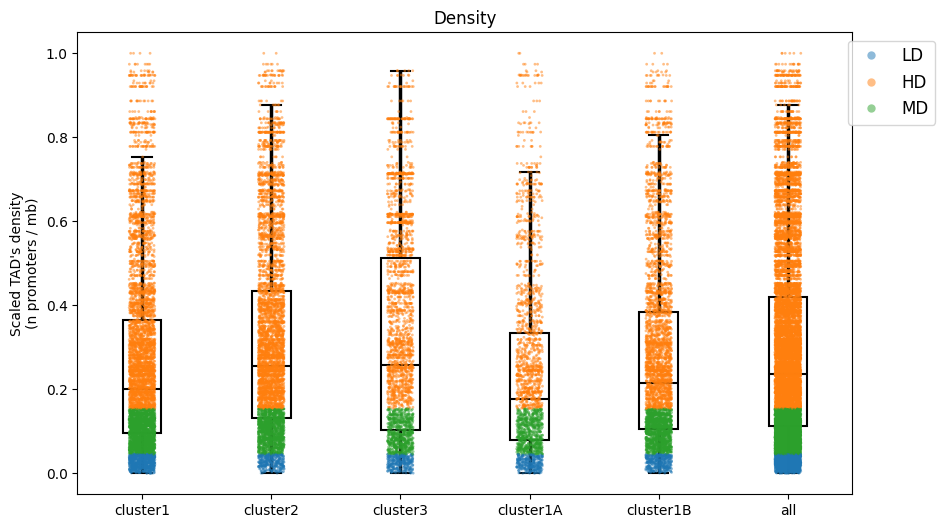

In [ ]:
png_path = part1_logs + 'density.png'
order = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B', 'all']

plt.figure(figsize=(10, 6))

sns.boxplot(data=df_proms_final, x='Cluster', y='scaled_density_val', color='white', linewidth=1.5, width=0.3,
            boxprops=dict(edgecolor='black'), whiskerprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='black', linewidth=1.5), meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=10)
            , showfliers=False, order=order)

sns.stripplot(data=df_proms_final, x='Cluster', y='scaled_density_val', hue='density_label', size=2, jitter=True, alpha=0.5, order=order)
plt.xlabel('')
plt.ylabel('Scaled TAD\'s density\n(n promoters / mb)')
plt.title('Density')

# Adjust legend font size, symbol size, and transparency
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper center', fontsize='large', handlelength=2, markerscale=3)

# Manually adjust whiskers
for line in plt.gca().lines:
    if (line.get_linestyle() == '-'):  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity
plt.savefig(png_path)

plt.show()

# Cluster2 and Cluster3 seem to have more density than the expected -> make p test

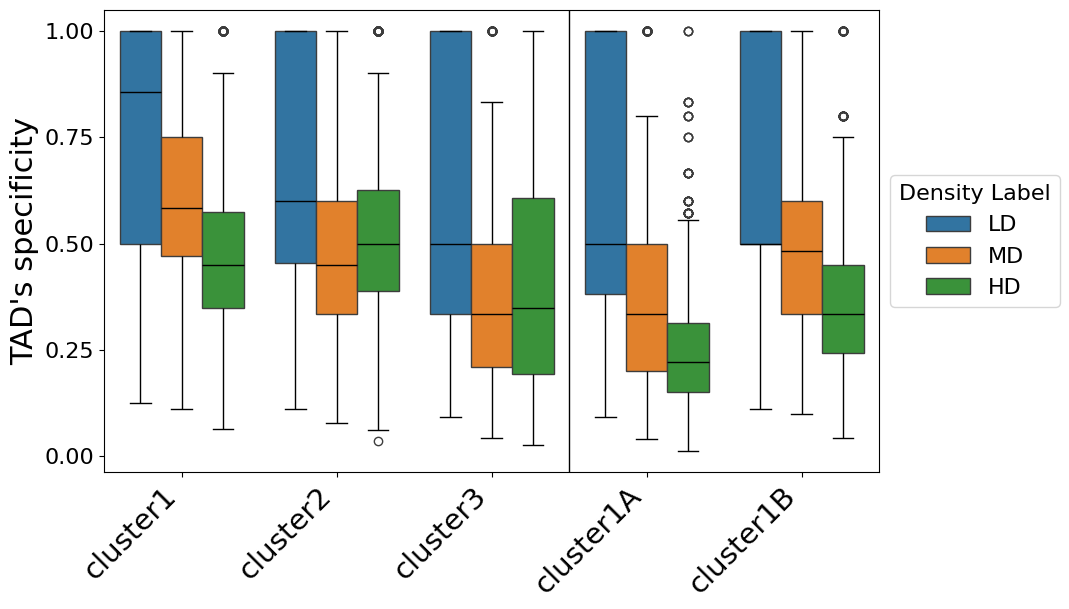

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define order and colors
order = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B']
colours = {'LD': 'blue', 'MD': 'orange', 'HD': 'green'}
colours = {'LD': '#1f77b4', 'MD': '#ff7f0e', 'HD': '#2ca02c'}

#color=['#1f77b4', '#ff7f0e', '#2ca02c'])
size = 22
smaller_size = size - 6

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot boxplot
sns.boxplot(data=df_proms_final, x='Cluster', y='cluster_specificity', hue='density_label',
            palette=colours, hue_order=['LD', 'MD', 'HD'], order=order, ax=ax)


# Set labels and title
ax.set_ylabel('TAD\'s specificity', fontsize=size)
ax.set_xlabel('')

# Manually adjust whiskers
for line in ax.lines:
    if line.get_linestyle() == '-':  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity

plt.axvline(x=order.index('cluster1A') - 0.5, color='black', linestyle='-', linewidth=1.0)

# Set y-tick labels
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=smaller_size)
# Set x-tick labels
plt.xticks(rotation=45, ha='right', fontsize=size-1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Density Label', fontsize=smaller_size, title_fontsize= smaller_size)

# Hide the legend
#ax.get_legend().remove()


plt.show()


In [ ]:
df_proms_final

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1,cluster2,cluster3,cluster1A,cluster1B,scaled_density_val,scaled_length,cluster_specificity,promoter_range
0,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.000000,0.200000,0.000000,0.200000,0.600000,0.033886,0.533798,0.200000,<10
1,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.000000,0.000000,0.500000,0.500000,0.000000,0.007656,0.691326,0.500000,<5
2,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
3,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
4,Slco5a1,cluster1A,TAD12862000-13656000,0.794,4.0,5.037783,MD,0.000000,0.500000,0.000000,0.250000,0.250000,0.068339,0.215550,0.250000,<5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37872,Gm21677,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37873,Gm21693,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37874,Gm21704,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37875,Gm21708,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15


In [ ]:
# Assuming df_proms is your dataframe
cluster1B_median = df_proms_final[(df_proms_final['Cluster'] == 'cluster1B') & (df_proms_final['density_label'] == 'LD')]['cluster_specificity'].median()
print(cluster1B_median)

0.5


In [ ]:
# Assuming df_proms is your dataframe
cluster1B_median = df_proms_final[df_proms_final['Cluster'] == 'cluster3']['scaled_length'].median()
print(cluster1B_median)

0.2445604873803307


<ipython-input-46-e75df4d0b383>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proms_final, x='Cluster', y='scaled_density_val', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,


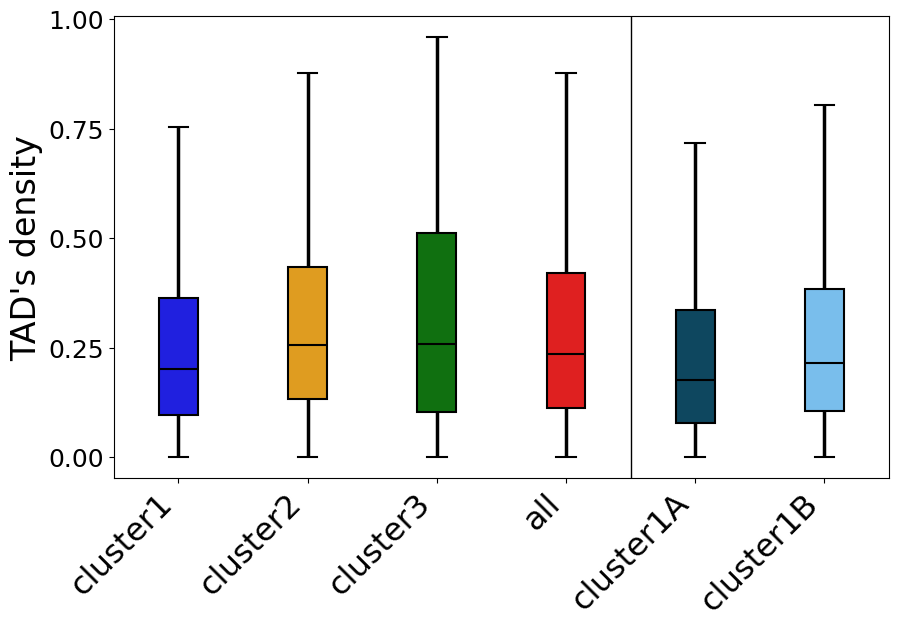

In [ ]:
# Path to save the plot
png_path = part1_dir + 'density.png'

# Define order of clusters
order = ['cluster1', 'cluster2', 'cluster3', 'all', 'cluster1A', 'cluster1B']

# Define color palette for clusters
cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red', 'HK': 'purple'}

# Set the size for labels and ticks
size = 24
smaller_size = size - 6

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_proms_final, x='Cluster', y='scaled_density_val', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,
            boxprops=dict(edgecolor='black'), whiskerprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='white', linewidth=1.5),  # Set median line color to white
            meanprops=dict(marker='o', markerfacecolor='white', markeredgecolor='white', markersize=10),
            showfliers=False, order=order)

# Add a vertical line as separator before 'cluster1A'
plt.axvline(x=order.index('cluster1A') - 0.5, color='black', linestyle='-', linewidth=1.0)
# Remove x-label
plt.xlabel('')

# Set y-label
plt.ylabel("TAD's density", fontsize=size)

# Set y-tick labels
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=smaller_size)

# Set x-tick labels
plt.xticks(rotation=45, ha='right', fontsize=size-1)


# Manually adjust whiskers
for line in plt.gca().lines:
    if line.get_linestyle() == '-':  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity

# Save and show the plot
plt.savefig(png_path, bbox_inches='tight')  # Use bbox_inches='tight' to include legend properly
plt.show()


In [ ]:
from scipy.stats import ttest_ind

column = 'density_val'
clusters = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B', 'all']

p_values_df = pd.DataFrame(index=clusters, columns=clusters)

for i in range(len(clusters)):
    for j in range(i+1, len(clusters)):
        cluster1 = clusters[i]
        cluster2 = clusters[j]
        data1 = df_proms_final[df_proms_final['Cluster'] == cluster1][column]
        data2 = df_proms_final[df_proms_final['Cluster'] == cluster2][column]
        t_statistic, p_value = ttest_ind(data1, data2)

        # Set a threshold for significance
        threshold = 0.05
        if p_value < threshold:
            p_values_df.at[cluster1, cluster2] = f"{p_value:.2e}"
            p_values_df.at[cluster2, cluster1] = f"{p_value:.2e}"
        else:
            p_values_df.at[cluster1, cluster2] = 'Not Significant'
            p_values_df.at[cluster2, cluster1] = 'Not Significant'

p_values_df

,cluster1,cluster2,cluster3,cluster1A,cluster1B,all
cluster1,NaN,2.48e-36,1.63e-28,2.77e-05,9.17e-03,2.48e-19
cluster2,2.48e-36,NaN,Not Significant,1.02e-38,9.87e-19,3.33e-09
cluster3,1.63e-28,Not Significant,NaN,1.38e-32,3.69e-16,2.44e-08
cluster1A,2.77e-05,1.02e-38,1.38e-32,NaN,3.90e-09,4.79e-24
cluster1B,9.17e-03,9.87e-19,3.69e-16,3.90e-09,NaN,1.25e-06
all,2.48e-19,3.33e-09,2.44e-08,4.79e-24,1.25e-06,NaN


<ipython-input-48-1f3dd673d32b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proms_final, x='Cluster', y='cluster_specificity', linewidth=1.5, width=0.3,


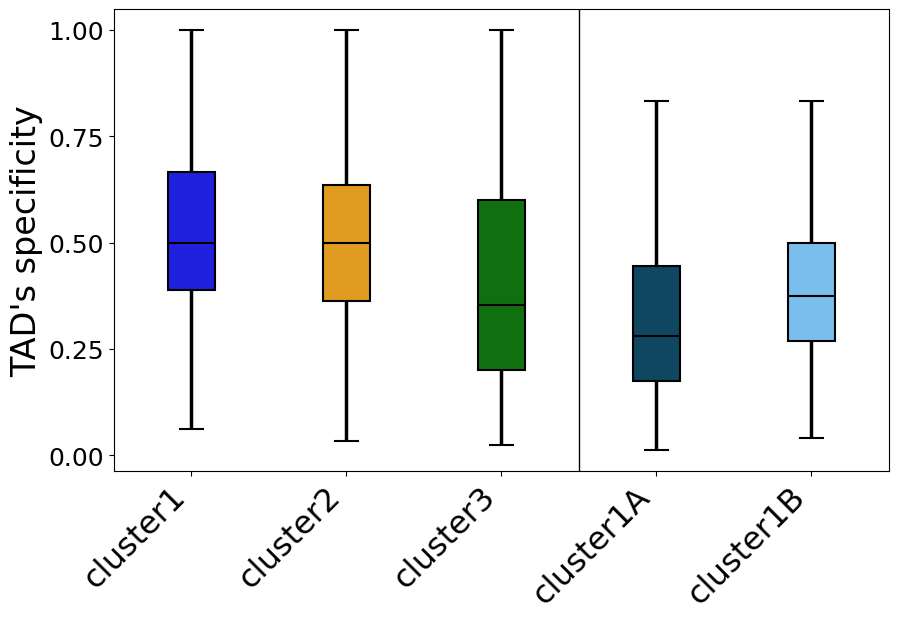

In [ ]:

order = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B']
png_path = part1_dir + 'specificity.png'

size = 24
smaller_size = size - 6

# Define a color palette for each cluster
cluster_palette = {'cluster1' : 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all' : 'red', 'HK' : 'purple'}

plt.figure(figsize=(10, 6))

# Plot boxplot with different colors for each cluster
sns.boxplot(data=df_proms_final, x='Cluster', y='cluster_specificity', linewidth=1.5, width=0.3,
            palette=cluster_palette, boxprops=dict(edgecolor='black'), whiskerprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='black', linewidth=1.5), meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=10),
            showfliers=False, order=order)

# Add horizontal lines
#plt.axhline(y=0.25, color='gray', linestyle='--', linewidth=0.75)
#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.75)
#plt.axhline(y=0.75, color='gray', linestyle='--', linewidth=0.75)
# Add a vertical line as separator before 'cluster1A'
plt.axvline(x=order.index('cluster1A') - 0.5, color='black', linestyle='-', linewidth=1.0)
plt.xlabel('')
plt.ylabel('TAD\'s specificity', fontsize=size)
#plt.title('Specificity')
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=smaller_size)  # Specify the positions of the y-ticks
plt.xticks(rotation=45, ha='right', fontsize=size - 1)

# Manually adjust whiskers
for line in plt.gca().lines:
    if (line.get_linestyle() == '-'):  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity

plt.savefig(png_path, bbox_inches='tight')  # Use bbox_inches='tight' to include legend properly
plt.show()


<ipython-input-49-3bbaf702b342>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proms_final, x='Cluster', y='scaled_length', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,


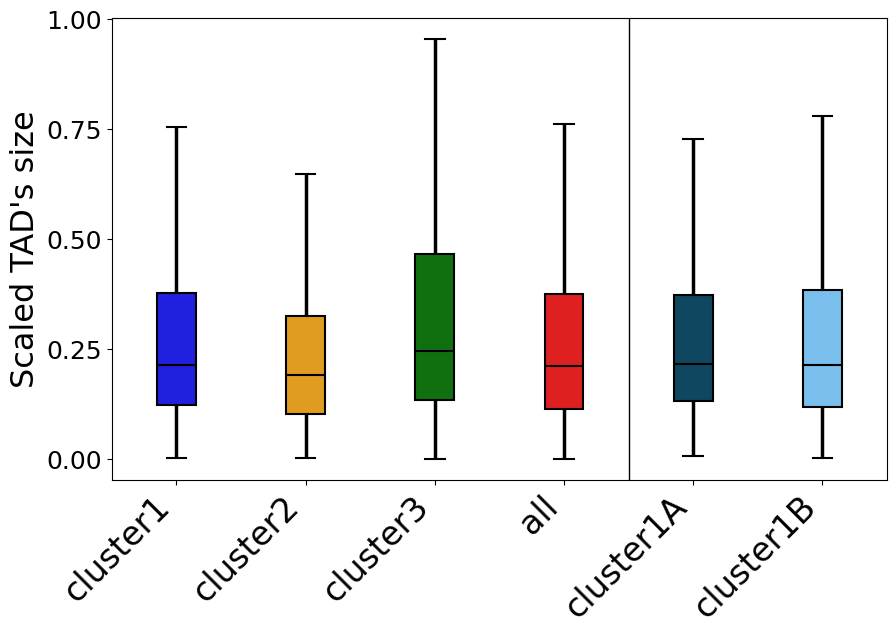

In [ ]:
order = ['cluster1', 'cluster2', 'cluster3', 'all', 'cluster1A', 'cluster1B']
png_path = part1_dir + 'length.png'
cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red', 'HK': 'purple'}

size = 24
smaller_size = size - 6

plt.figure(figsize=(10, 6))

sns.boxplot(data=df_proms_final, x='Cluster', y='scaled_length', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,
            boxprops=dict(edgecolor='black'), whiskerprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='black', linewidth=1.5), meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=10)
            , showfliers=False, order=order)

# Add horizontal lines
#plt.axhline(y=0.25, color='gray', linestyle='--', linewidth=0.75)
#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.75)
#plt.axhline(y=0.75, color='gray', linestyle='--', linewidth=0.75)
plt.axvline(x=order.index('cluster1A') - 0.5, color='black', linestyle='-', linewidth=1.0)

plt.xlabel('')
plt.ylabel('Scaled TAD\'s size', fontsize = size - 1)
#plt.title('Size', fontsize = 12)

plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=smaller_size)  # Specify the positions of the y-ticks
plt.xticks(rotation=45, ha='right', fontsize=size)

#plt.ylim(0, 1)  # Adjust the limits as needed

# Manually adjust whiskers
for line in plt.gca().lines:
    if (line.get_linestyle() == '-'):  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity

plt.savefig(png_path, bbox_inches='tight')  # Use bbox_inches='tight' to include legend properly
plt.show()

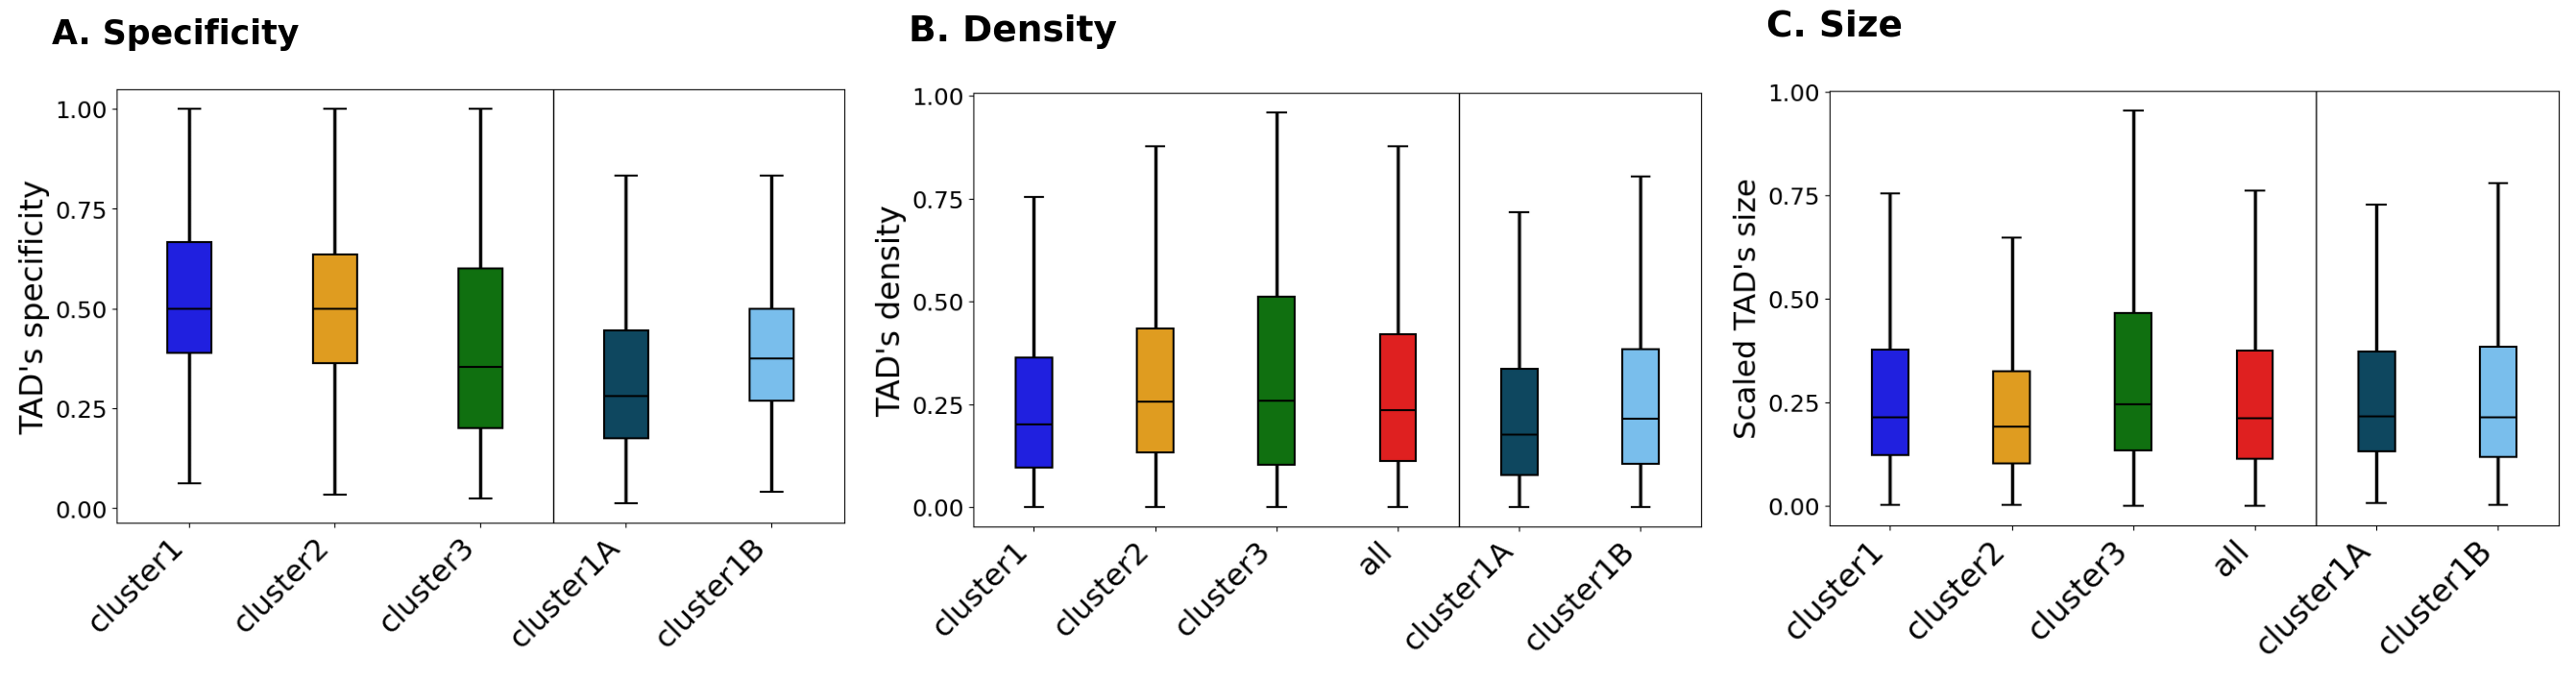

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the three images
image1 = Image.open(part1_dir + 'specificity.png')
image2 = Image.open(part1_dir + 'density.png')
image3 = Image.open(part1_dir + 'length.png')

# Create a figure with 2x2 subplots
#aspect_ratios = [image1.width / image1.height, image2.width / image2.height, image3.width / image3.height]

total_width = image1.width + image2.width + image3.width
figsize = (total_width / 100, total_width / 300)

#figsize_width = 15
#figsize_height = figsize_width / sum(aspect_ratios)
#figsize = (figsize_width, figsize_height)

#figsize=(15, 10)
# Create a figure with 1x3 subplots
#fig, axs = plt.subplots(1, 3, figsize=figsize)
fig, axs = plt.subplots(1, 3, figsize=figsize)

# Set titles for each subplot with smaller font size
axs[0].set_title('A. Specificity', fontsize=25, fontweight='bold', loc='left', x=0.05, y=1.05)
axs[1].set_title('B. Density', fontsize=27, fontweight='bold', loc='left', x=0.05, y=1.05)
axs[2].set_title('C. Size', fontsize=27, fontweight='bold', loc='left', x=0.05, y=1.05)

# Display each image in its respective subplot
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)

# Hide axes
for ax in axs.flatten():
    ax.axis('off')

#plt.subplots_adjust(wspace=0.05)  # Adjust wspace as needed

# Adjust layout
plt.tight_layout()

In [ ]:
column = 'length'
clusters = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B', 'all']

p_values_df = pd.DataFrame(index=clusters, columns=clusters)

for i in range(len(clusters)):
    for j in range(i+1, len(clusters)):
        cluster1 = clusters[i]
        cluster2 = clusters[j]
        data1 = df_proms_final[df_proms_final['Cluster'] == cluster1][column]
        data2 = df_proms_final[df_proms_final['Cluster'] == cluster2][column]
        t_statistic, p_value = ttest_ind(data1, data2)
        p_values_df.at[cluster1, cluster2] = p_value #f"{p_value:.2e}"

        # Set a threshold for significance
        #threshold = 0.05
        #if p_value < threshold:
        #    p_values_df.at[cluster1, cluster2] = f"{p_value:.2e}"
        #    p_values_df.at[cluster2, cluster1] = f"{p_value:.2e}"
        #else:
        #    p_values_df.at[cluster1, cluster2] = 'Not Significant'
        #    p_values_df.at[cluster2, cluster1] = 'Not Significant'

p_values_df

,cluster1,cluster2,cluster3,cluster1A,cluster1B,all
cluster1,NaN,0.0,0.0,0.941864,0.964158,0.071218
cluster2,NaN,NaN,0.0,0.0,0.0,0.0
cluster3,NaN,NaN,NaN,0.0,0.0,0.0
cluster1A,NaN,NaN,NaN,NaN,0.918864,0.21474
cluster1B,NaN,NaN,NaN,NaN,NaN,0.133522
all,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from PIL import Image

# Open the three images
image1 = Image.open(part1_logs + 'specificity.png')
image2 = Image.open(part1_logs + 'density.png')
image3 = Image.open(part1_logs + 'length.png')

# Get the sizes of the images
width1, height1 = image1.size
width2, height2 = image2.size
width3, height3 = image3.size

# Calculate the total width and height for the combined image
total_width = width1 + width2 + width3
max_height = max(height1, height2, height3)

# Create a new blank image with the combined size
combined_image = Image.new('RGB', (total_width, max_height))

# Paste each image into the combined image
combined_image.paste(image1, (0, 0))
combined_image.paste(image2, (width1, 0))
combined_image.paste(image3, (width1 + width2, 0))

# Save the combined image
combined_image.save(part1_logs + 'combined_plots.png')

# Display the combined image
combined_image.show()


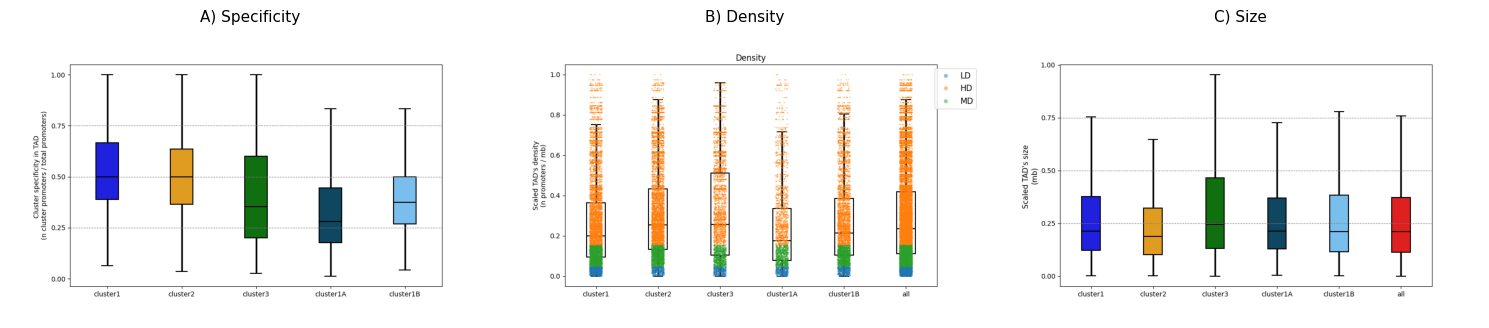

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the three images
image1 = Image.open(part1_logs + 'specificity.png')
image2 = Image.open(part1_logs + 'density.png')
image3 = Image.open(part1_logs + 'length.png')

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Set titles for each subplot with smaller font size
axs[0].set_title('A) Specificity', fontsize=11)
axs[1].set_title('B) Density', fontsize=11)
axs[2].set_title('C) Size', fontsize=11)

# Display each image in its respective subplot
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)

# Hide axes
for ax in axs:
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

<ipython-input-54-9b43c7216422>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Cluster', y='cluster_specificity', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,
<ipython-input-54-9b43c7216422>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Cluster', y='cluster_specificity', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,
<ipython-input-54-9b43c7216422>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Cluster', y='cluster_specificity', c

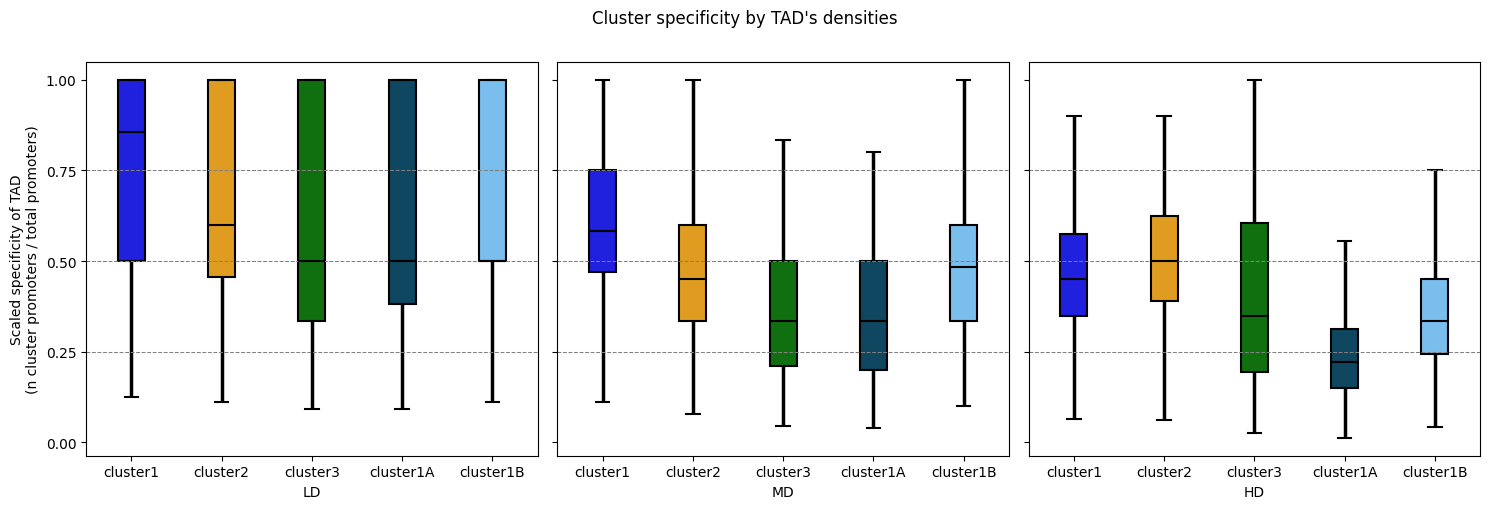

In [ ]:
# Define order and colours
order = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B']
colours = {'LD': 'blue', 'MD': 'orange', 'HD': 'green'}
cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red', 'HK': 'purple'}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Iterate over unique values in 'density_label'
for i, label in enumerate(['LD', 'MD', 'HD']):

    # Filter DataFrame for the current 'density_label'
    filtered_df = df_proms_final[(df_proms_final['density_label'] == label) & (df_proms_final['Cluster'] != 'all')]
    colour = 'black'

    # Plot boxplot in the corresponding subplot
    sns.boxplot(data=filtered_df, x='Cluster', y='cluster_specificity', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,
                boxprops=dict(edgecolor=colour), whiskerprops=dict(color=colour, linewidth=2.5),
                medianprops=dict(color=colour, linewidth=1.5), meanprops=dict(marker='o', markerfacecolor=colour, markeredgecolor=colour, markersize=10),
                showfliers=False, order=order, ax=axes[i])

    axes[i].set_xlabel(f'{label}')
    axes[i].set_ylabel('Scaled specificity of TAD\n(n cluster promoters / total promoters)')
    #axes[i].set_title(f'Specificity ({label})')
        # Set y ticks
    axes[i].set_yticks([0, 0.25, 0.5, 0.75, 1.0])

    # Add horizontal lines
    axes[i].axhline(y=0.25, color='gray', linestyle='--', linewidth=0.75)
    axes[i].axhline(y=0.5, color='gray', linestyle='--', linewidth=0.75)
    axes[i].axhline(y=0.75, color='gray', linestyle='--', linewidth=0.75)

# Set common title
fig.suptitle('Cluster specificity by TAD\'s densities', fontsize=12, y=1.01)

# Manually adjust whiskers
for ax in axes:
    for line in ax.lines:
        if (line.get_linestyle() == '-'):  # Ensure it's a solid line
            line.set_color(f'black')
            line.set_alpha(1.0)  # Ensure full opacity

# Add legend outside the subplots
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colours[label], markersize=10, label=label) for label in colours.keys()]
#fig.legend(handles=handles, labels=colours.keys(), title='Density', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

In [ ]:
df_proms_final

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1,cluster2,cluster3,cluster1A,cluster1B,scaled_density_val,scaled_length,cluster_specificity,promoter_range
0,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.000000,0.200000,0.000000,0.200000,0.600000,0.033886,0.533798,0.200000,<10
1,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.000000,0.000000,0.500000,0.500000,0.000000,0.007656,0.691326,0.500000,<5
2,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
3,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
4,Slco5a1,cluster1A,TAD12862000-13656000,0.794,4.0,5.037783,MD,0.000000,0.500000,0.000000,0.250000,0.250000,0.068339,0.215550,0.250000,<5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37872,Gm21677,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37873,Gm21693,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37874,Gm21704,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37875,Gm21708,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15


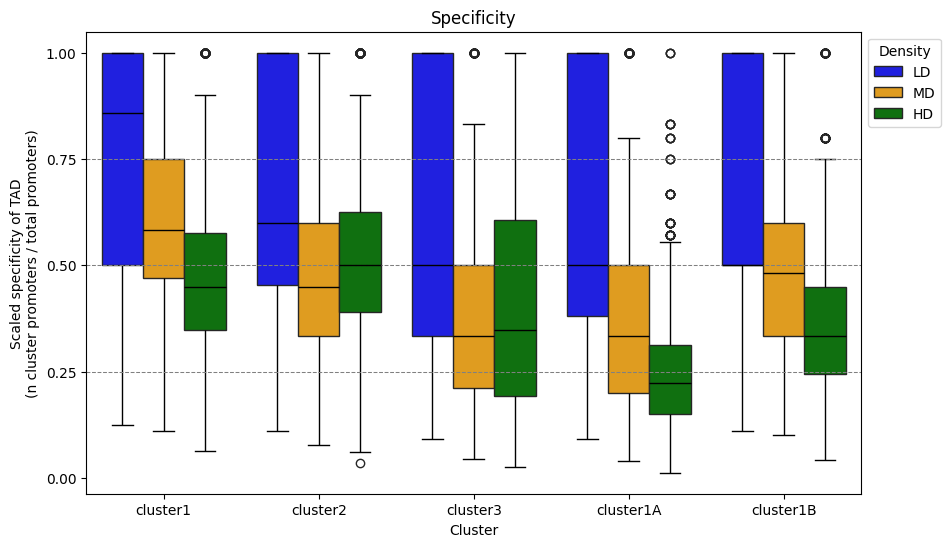

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define order and colours
order = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B']
colours = {'LD': 'blue', 'MD': 'orange', 'HD': 'green'}

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot boxplot
sns.boxplot(data=df_proms_final, x='Cluster', y='cluster_specificity', hue='density_label',
            palette=colours, hue_order=['LD', 'MD', 'HD'], order=order, ax=ax)

# Set labels and title
#ax.set_xlabel('')
ax.set_ylabel('Scaled specificity of TAD\n(n cluster promoters / total promoters)')
ax.set_title('Specificity')

# Manually adjust whiskers
for line in ax.lines:
    if line.get_linestyle() == '-':  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity

# Add legend outside the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Density', loc='upper left', bbox_to_anchor=(1,1))
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])

# Add horizontal lines
ax.axhline(y=0.25, color='gray', linestyle='--', linewidth=0.75)
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.75)
ax.axhline(y=0.75, color='gray', linestyle='--', linewidth=0.75)

plt.show()

**Specificity randomization**

In [ ]:
def SpecificityRandomizationTest(df):

  for permutation in range(n_permutations):

    if permutation == 0:
      permutation = 'observed'
    else:
      Promoter.CreateRandomClusters(cluster_sizes)

    Tad.CalculateSpecificities(clusters)
    new_row = {cluster: 0 for cluster in clusters}
    new_row['permutation'] = permutation
    for cluster in clusters:
      cluster_vals = []
      cluster_promoters = Promoter.RetrieveClusterMembers(cluster)
      for prom in cluster_promoters:
        # Get tad of that promoter
        tad = next(iter(prom.tads))
        if tad == 'Bin0': # inter-TAD
          continue
        else:
          # Get specificity for the cluster
          val = float(tad.specificity[cluster])
          cluster_vals.append(val)
      mean = np.mean(cluster_vals)
      new_row[cluster] = mean

    df.loc[len(df)] = new_row
  return df

def CalculatePvalues(df_permuted, df_pvalues):

  new_row = {key : 0 for key in columns}

  for column in df_permuted.columns[1:]:

    observed_value = df_permuted.loc[df_permuted['permutation'] == 'observed', column].values[0]
    permuted_data = df_permuted.loc[df_permuted['permutation'] != 'observed', column].values

    mu, std = np.mean(permuted_data), np.std(permuted_data)
    normal_dist = norm(loc=mu, scale=std)

    # Kolmogorov-Smirnov test for goodness of fit of our data to a normal distributionn
    statistic, p_value = kstest(permuted_data, normal_dist.cdf)

    #If the p-value is high (e.g., greater than 0.05), it suggests that the data is likely to be drawn from the normal distribution.
    if p_value < 0.05:
      print("Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data:", cluster, column, statistic, p_value)

    # Once we know that it follows a normal distribution, we calculate probability of the observed value
    pdf_at_obs = normal_dist.pdf(observed_value) # p-value or probability of finding the value in the random distribution

    print(pdf_at_obs)
    #pdf_at_obs_formatted = "{:.10f}".format(pdf_at_obs)
    new_row[column] = pdf_at_obs

  df_pvalues.loc[len(df_pvalues)] = new_row
  return df_pvalues

In [ ]:
# Randomization for TAD specificity parameter
n_permutations = 1000
read_flag = True
# Perform for cluster1A, cluster1B, cluster2, cluster3
csv_path = part1_logs + 'specificity_permuted_c1A1B.csv'

if os.path.exists(csv_path) and read_flag:
    df_c1A1B = pd.read_csv(csv_path)
else:
  cluster_sizes = {'cluster1A': 2581, 'cluster1B': 6001, 'cluster2': 7988, 'cluster3': 4049}
  clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
  columns = ['permutation'] + clusters
  df_c1A1B = pd.DataFrame(columns=columns)

  Promoter.SetOriginalClusters('cluster1AB')

  df_c1A1B = SpecificityRandomizationTest(df_c1A1B)
  df_c1A1B.to_csv(csv_path, index=False)

# Perform for cluster1, cluster2, cluster3
csv_path = part1_logs + 'specificity_permuted_c1.csv'

if os.path.exists(csv_path) and read_flag:
    df_c1 = pd.read_csv(csv_path)
else:
  cluster_sizes = {'cluster1': 8582, 'cluster2': 7988, 'cluster3': 4049}
  clusters = ['cluster1', 'cluster2', 'cluster3']
  columns = ['permutation'] + clusters
  df_c1 = pd.DataFrame(columns=columns)

  Promoter.SetOriginalClusters('cluster1')

  df_c1 = SpecificityRandomizationTest(df_c1)
  df_c1.to_csv(csv_path, index=False)

In [ ]:
# Calculate p_values

read_flag = False

# Perform for cluster1A, cluster1B, cluster2, cluster3
csv_path = part1_logs + 'specificity_pvalues_c1A1B.csv'

if os.path.exists(csv_path) and read_flag:
    df_pvalues_c1A1B = pd.read_csv(csv_path)
else:
  clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
  columns = clusters
  df_pvalues_c1A1B = pd.DataFrame(columns=columns)
  df_pvalues_c1A1B = CalculatePvalues(df_c1A1B, df_pvalues_c1A1B)
  df_pvalues_c1A1B.to_csv(csv_path, index=False)

# Perform for cluster1, cluster2, cluster3
csv_path = part1_logs + 'specificity_pvalues_c1.csv'

if os.path.exists(csv_path) and read_flag:
    df_pvalues_c1 = pd.read_csv(csv_path)
else:
  clusters = ['cluster1', 'cluster2', 'cluster3']
  columns = clusters
  df_pvalues_c1 = pd.DataFrame(columns=columns)
  df_pvalues_c1 = CalculatePvalues(df_c1, df_pvalues_c1)
  df_pvalues_c1.to_csv(csv_path, index=False)

4.6939126966510845e-102
1.9370708075788874e-10
2.319735807531447e-23
2.1246129597954062e-157
1.2523455892809284e-63
1.440151998657604e-25
1.3944147501084693e-159


In [ ]:
df_pvalues_c1A1B

,cluster1A,cluster1B,cluster2,cluster3
0,4.693913e-102,1.937071e-10,2.319736e-23,2.124613e-157


In [ ]:
df_pvalues_c1

,cluster1,cluster2,cluster3
0,1.252346e-63,1.440152e-25,1.394415e-159


In [ ]:
def plot_distributions(column_name, png_path):
    plt.figure(figsize=(15, 12))
    for i, row in df_distributions.iterrows():
        cluster = row["Cluster"]
        plt.subplot(2, 3, i+1)
        values = row[column_name]
        weights = np.ones_like(values) / len(values)
        plt.hist(values, bins=50, weights=weights, alpha=0.5, label='Permuted', color='blue')
        observed_col_name = column_name.strip('Bin')
        observed_value = df_observed.loc[df_observed['Cluster'] == cluster, observed_col_name].iloc[0]
        plt.axvline(x=observed_value, color='red', linestyle='dashed', linewidth=2, label='Observed')
        plt.title(cluster)
        plt.legend()
        #plt.ylim(0.0, 0.5)
        plt.xlim(12, 32)

    # Set super title
    plt.suptitle(f'Distribution of values for {column_name}')

    plt.tight_layout()
    plt.savefig(png_path)
    plt.show()

# Perform for cluster1A, cluster1B, cluster2, cluster3
csv_path = part1_logs + 'specificity_distributions_c1A1B.csv'

if os.path.exists(csv_path) and read_flag:
    df_c1A1B = pd.read_csv(csv_path)
else:
  cluster_sizes = {'cluster1A': 2581, 'cluster1B': 6001, 'cluster2': 7988, 'cluster3': 4049}
  clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
  columns = clusters
  df_dist_c1A1B = pd.DataFrame(columns=columns)
  new_row = {key: [] for key in clusters}
  for column in columns:
    permuted_data = df_c1A1B.loc[df_c1A1B['permutation'] != 'observed', column].values
    new_row[column] = permuted_data
  df_dist_c1A1B.loc[len(df_dist_c1A1B)] = new_row

# Perform for cluster1, cluster2, cluster3
csv_path = part1_logs + 'specificity_distributions_c1.csv'

if os.path.exists(csv_path) and read_flag:
    df_c1 = pd.read_csv(csv_path)
else:
  cluster_sizes = {'cluster1': 8582, 'cluster2': 7988, 'cluster3': 4049}
  clusters = ['cluster1', 'cluster2', 'cluster3']
  columns = clusters
  df_dist_c1 = pd.DataFrame(columns=columns)
  new_row = {key: [] for key in clusters}
  for column in columns:
    permuted_data = df_c1.loc[df_c1['permutation'] != 'observed', column].values
    new_row[column] = permuted_data

  df_dist_c1.loc[len(df_dist_c1)] = new_row


  df_dist_c1.to_csv(csv_path, index=False)


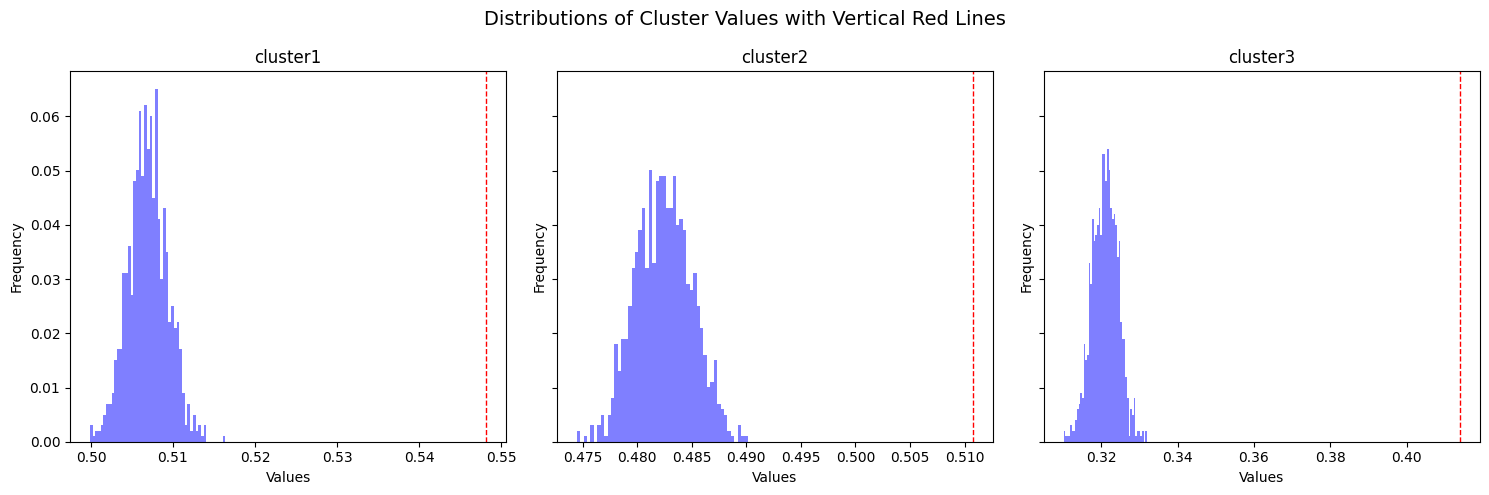

In [ ]:
# Assuming df_dist_c1 is your DataFrame
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Position for the vertical line
  # Adjust this as needed

for i, col in enumerate(df_dist_c1.columns):
    values = df_dist_c1[col].values[0]  # Get the array of values from the DataFrame
    weights = np.ones_like(values) / len(values)  # Normalize weights
    axes[i].hist(values, bins=50, weights=weights, alpha=0.5, label='Permuted', color='blue')
    axes[i].set_title(col)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')
    observed_value = df_c1.loc[df_c1['permutation'] == 'observed', col].values[0]

    # Add vertical line
    axes[i].axvline(x=observed_value, color='red', linestyle='--', linewidth=1)

plt.suptitle('Distributions of Cluster Values with Vertical Red Lines', fontsize=14)
plt.tight_layout()
plt.show()

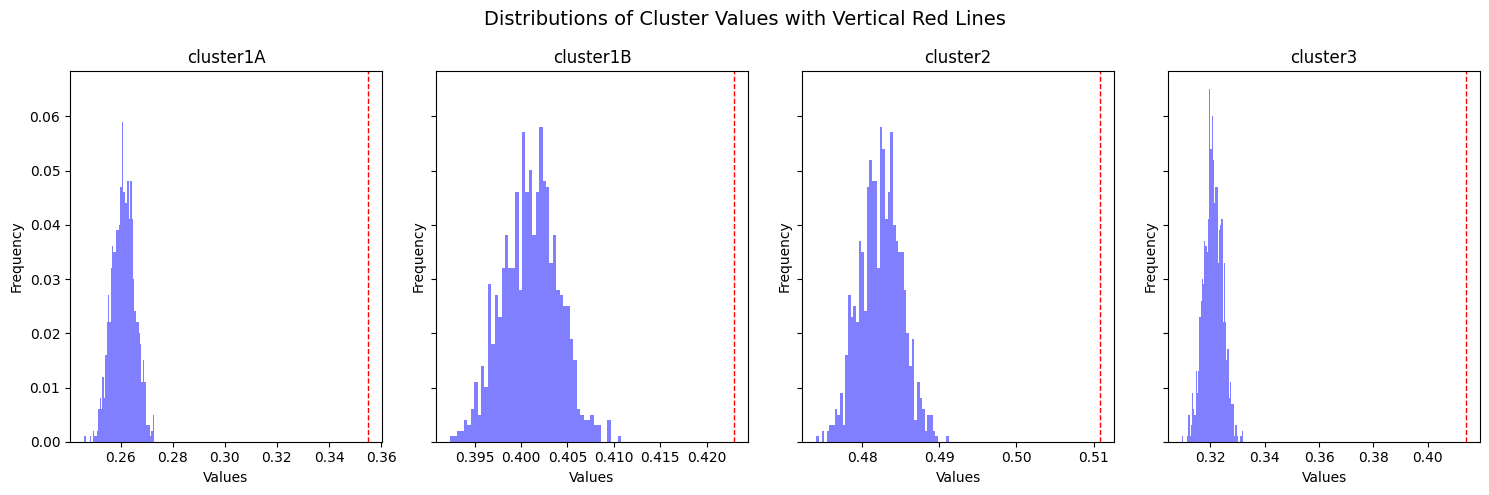

In [ ]:
# Assuming df_dist_c1 is your DataFrame
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)

# Position for the vertical line
  # Adjust this as needed

for i, col in enumerate(df_dist_c1A1B.columns):
    values = df_dist_c1A1B[col].values[0]  # Get the array of values from the DataFrame
    weights = np.ones_like(values) / len(values)  # Normalize weights
    axes[i].hist(values, bins=50, weights=weights, alpha=0.5, label='Permuted', color='blue')
    axes[i].set_title(col)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')
    observed_value = df_c1A1B.loc[df_c1A1B['permutation'] == 'observed', col].values[0]

    # Add vertical line
    axes[i].axvline(x=observed_value, color='red', linestyle='--', linewidth=1)

plt.suptitle('Distributions of Cluster Values with Vertical Red Lines', fontsize=14)
plt.tight_layout()
plt.show()

**Correlation matrix**

In [ ]:
df_proms_final

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1,cluster2,cluster3,cluster1A,cluster1B,scaled_density_val,scaled_length,cluster_specificity,promoter_range
0,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.000000,0.200000,0.000000,0.200000,0.600000,0.033886,0.533798,0.200000,<10
1,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.000000,0.000000,0.500000,0.500000,0.000000,0.007656,0.691326,0.500000,<5
2,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
3,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
4,Slco5a1,cluster1A,TAD12862000-13656000,0.794,4.0,5.037783,MD,0.000000,0.500000,0.000000,0.250000,0.250000,0.068339,0.215550,0.250000,<5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37872,Gm21677,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37873,Gm21693,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37874,Gm21704,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37875,Gm21708,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15


In [ ]:
from sklearn.preprocessing import MinMaxScaler
df_corr = df_proms_final.copy()
# Eliminate cluster 'all'
df_corr = df_corr[~df_corr['Cluster'].isin(['all', 'cluster1'])]
df_corr['scaled_n_proms'] = scaler.fit_transform(df_corr[['n_promoters']])

columns_to_retain = ['scaled_density_val', 'scaled_length', 'scaled_n_proms',	'cluster2',	'cluster3',	'cluster1A',	'cluster1B']  # List of columns to retain
df_corr2 = df_corr.loc[:, columns_to_retain]

df_corr2

,scaled_density_val,scaled_length,scaled_n_proms,cluster2,cluster3,cluster1A,cluster1B
0,0.033886,0.533798,0.032258,0.200000,0.000000,0.200000,0.600000
1,0.007656,0.691326,0.008065,0.000000,0.500000,0.500000,0.000000
2,0.230075,0.145634,0.064516,0.111111,0.111111,0.222222,0.555556
3,0.230075,0.145634,0.064516,0.111111,0.111111,0.222222,0.555556
4,0.068339,0.215550,0.024194,0.500000,0.000000,0.250000,0.250000
...,...,...,...,...,...,...,...
15591,0.076446,0.658544,0.096774,0.076923,0.230769,0.000000,0.692308
15592,0.076446,0.658544,0.096774,0.076923,0.230769,0.000000,0.692308
15593,0.076446,0.658544,0.096774,0.076923,0.230769,0.000000,0.692308
15594,0.005438,0.854366,0.008065,0.000000,1.000000,0.000000,0.000000


In [ ]:
# Perform correlation analysis
correlation_matrix = df_corr2.corr()

# Print correlation matrix
correlation_matrix

,scaled_density_val,scaled_length,scaled_n_proms,cluster2,cluster3,cluster1A,cluster1B
scaled_density_val,1.000000,-0.226683,0.597517,0.148118,0.106703,-0.186714,-0.118744
scaled_length,-0.226683,1.000000,0.437567,-0.197790,0.164123,0.022923,0.037129
scaled_n_proms,0.597517,0.437567,1.000000,-0.077350,0.296156,-0.148832,-0.089186
cluster2,0.148118,-0.197790,-0.077350,1.000000,-0.456081,-0.248630,-0.461269
cluster3,0.106703,0.164123,0.296156,-0.456081,1.000000,-0.321677,-0.234570
cluster1A,-0.186714,0.022923,-0.148832,-0.248630,-0.321677,1.000000,-0.253782
cluster1B,-0.118744,0.037129,-0.089186,-0.461269,-0.234570,-0.253782,1.000000


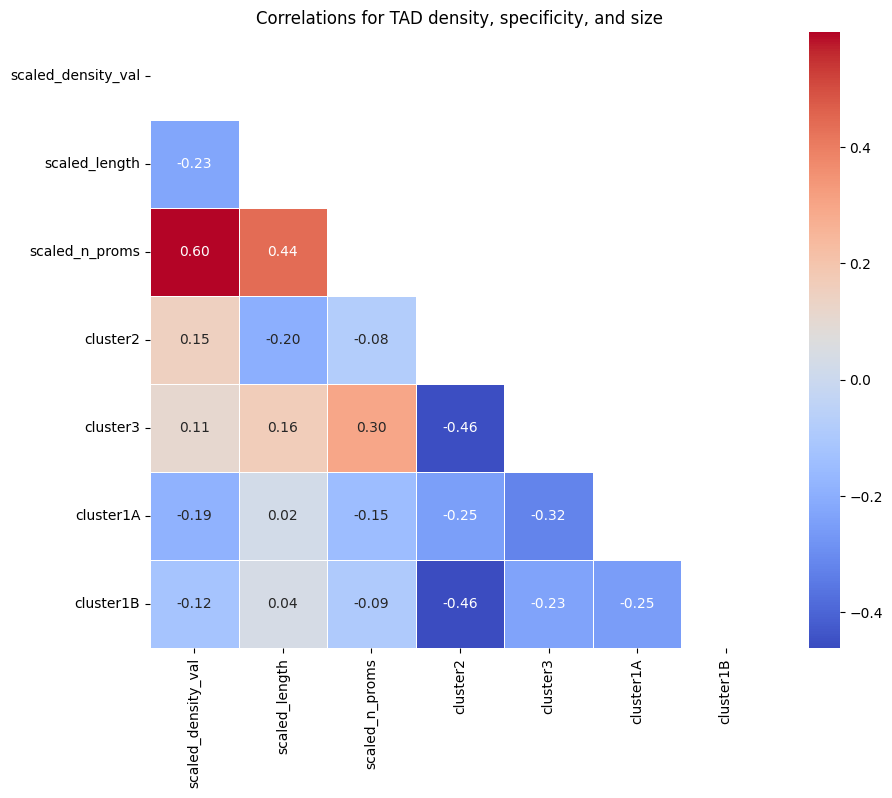

In [ ]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Correlations for TAD density, specificity, and size')
plt.show()

**FINAL FIGURES**

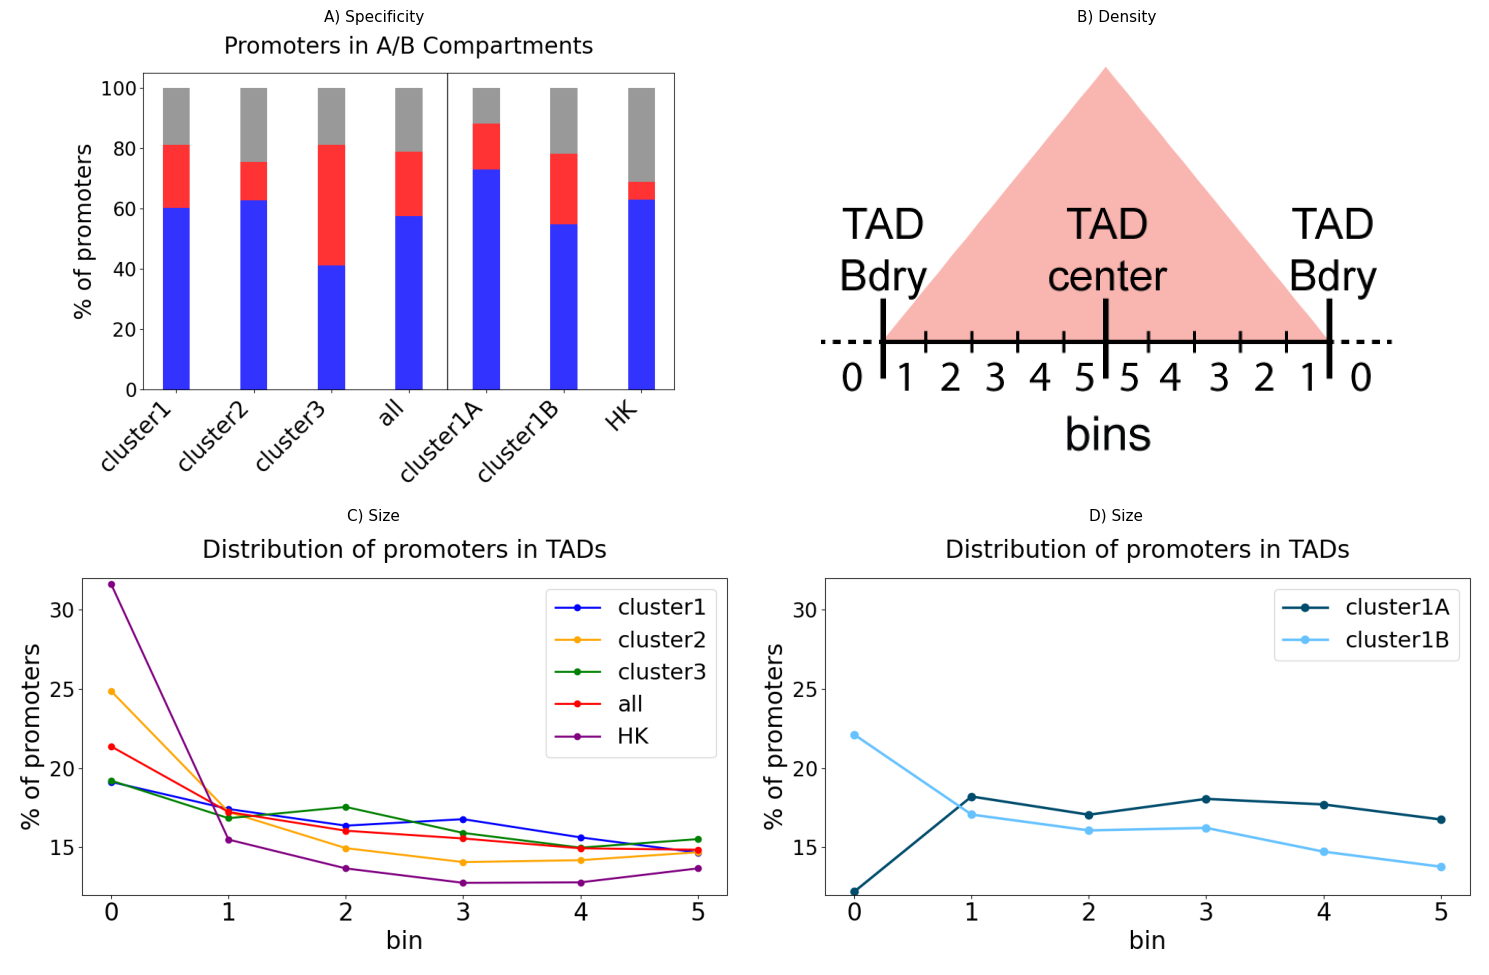

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the three images
image1 = Image.open(part1_dir + 'compartments_distribution.png')
image2 = Image.open(part1_dir + 'Alvaro_bins.png')
image3 = Image.open(part1_dir + 'distribution_bins.png')
image4 = Image.open(part1_dir + 'distribution_bins_1A_1B.png')

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Set titles for each subplot with smaller font size
axs[0, 0].set_title('A) Specificity', fontsize=11)
axs[0, 1].set_title('B) Density', fontsize=11)
axs[1, 0].set_title('C) Size', fontsize=11)
axs[1, 1].set_title('D) Size', fontsize=11)

# Display each image in its respective subplot
axs[0, 0].imshow(image1)
axs[0, 1].imshow(image2)
axs[1, 0].imshow(image3)
axs[1, 1].imshow(image4)

# Hide axes
for ax in axs.flatten():
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()